In [9]:
%matplotlib inline

In [10]:
from pathlib import Path
import re
import matplotlib.pyplot as plt
from matplotlib import pyplot
import eelbrain
import mne
#import trftools
from pprint import pprint
import numpy as np

import emd  # Ensure you ran: pip install EMD-signal
from scipy.signal import hilbert

import csv
import pandas as pd

In [11]:
## ESLs ##
## Import the raw EEG data of ESLs(Alice)

STIMULI = [str(i) for i in range(1, 13)]
DATA_ROOT = Path("/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results")
#DATA_ROOT = Path("/Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results")  #Path("~").expanduser() / 'Data' / 'Alice'
PREDICTOR_audio_DIR = DATA_ROOT / 'TRFs_pridictors/audio_predictors'
PREDICTOR_word_DIR = DATA_ROOT / 'TRFs_pridictors/word_predictors'
EEG_DIR = DATA_ROOT / 'EEG_ESLs' / 'Alice_ESL_ICAed_fif'
ESL_SUBJECTS = [path.name for path in EEG_DIR.iterdir() if re.match(r'n_2_S\d*', path.name)]  #S01_alice-raw.fif
# Define a target directory for TRF estimates and make sure the directory is created
TRF_DIR = DATA_ROOT / 'TRFs_ESLs'
TRF_DIR.mkdir(exist_ok=True)
print(ESL_SUBJECTS)
print(len(ESL_SUBJECTS))  # 26

DST = TRF_DIR / 'ESLs_figures'
DST.mkdir(exist_ok=True)

wOnset_DIR = DATA_ROOT / 'EEG_ESLs' / 'Alice_ESLs_wOnset_raw_epochs'
wOnset_DIR .mkdir(exist_ok=True)

['n_2_S030_ICAed_raw.fif', 'n_2_S027_ICAed_raw.fif', 'n_2_S023_ICAed_raw.fif', 'n_2_S034_ICAed_raw.fif', 'n_2_S024_ICAed_raw.fif', 'n_2_S019_ICAed_raw.fif', 'n_2_S020_ICAed_raw.fif', 'n_2_S013_ICAed_raw.fif', 'n_2_S017_ICAed_raw.fif', 'n_2_S039_ICAed_raw.fif', 'n_2_S010_ICAed_raw.fif', 'n_2_S029_ICAed_raw.fif', 'n_2_S015_ICAed_raw.fif', 'n_2_S028_ICAed_raw.fif', 'n_2_S011_ICAed_raw.fif', 'n_2_S038_ICAed_raw.fif', 'n_2_S016_ICAed_raw.fif', 'n_2_S012_ICAed_raw.fif', 'n_2_S021_ICAed_raw.fif', 'n_2_S036_ICAed_raw.fif', 'n_2_S032_ICAed_raw.fif', 'n_2_S025_ICAed_raw.fif', 'n_2_S035_ICAed_raw.fif', 'n_2_S022_ICAed_raw.fif', 'n_2_S026_ICAed_raw.fif', 'n_2_S031_ICAed_raw.fif']
26


In [12]:
# Import the csv data
csv_data = DATA_ROOT / "Alice(EEG_mat_and stimuli)" / "AliceChapterOne-EEG.csv"  # self-made LMM data form


word_onset_LIST = []
with open(csv_data, "r", encoding="UTF-8") as f:
    fileDF = pd.read_csv(f, sep=",")
    #print(fileDF.columns)
    # word_onset = fileDF["onset"]
    # print(word_onset, type(word_onset))

    word_onset_essentials_DF = fileDF.iloc[:,[0, 1, 2] ]     # first column
    #print(word_onset_essentials_DF["onset"], word_onset_essentials_DF["onset"])
    #print()

    for i in range(1, 13):
        print(i)
        #w_S = word_onset_essentials_DF.loc[:, [i]["Word"]]
        #wOnset_F = word_onset_essentials_DF.loc[:, 2]
        #print(w_S)

        wOnset_DF = word_onset_essentials_DF.loc[word_onset_essentials_DF["Segment"] == 2, :]
        print(wOnset_DF, type(wOnset_DF))
        print(wOnset_DF["onset"])
        """
        if 
        w_S = word_onset_essentials_DF.iloc[i, 0]
        wOnset_F = word_onset_essentials_DF.iloc[i, 2]
        print(w_S, wOnset_F)
        """

1
         Word  Segment      onset
174       but        2   0.479840
175      when        2   0.592424
176       the        2   0.810806
177    Rabbit        2   0.912952
178  actually        2   1.415810
..        ...      ...        ...
346       was        2  58.681660
347     going        2  58.861252
348        to        2  59.148599
349    happen        2  59.251158
350      next        2  59.687374

[177 rows x 3 columns] <class 'pandas.core.frame.DataFrame'>
174     0.479840
175     0.592424
176     0.810806
177     0.912952
178     1.415810
         ...    
346    58.681660
347    58.861252
348    59.148599
349    59.251158
350    59.687374
Name: onset, Length: 177, dtype: float64
2
         Word  Segment      onset
174       but        2   0.479840
175      when        2   0.592424
176       the        2   0.810806
177    Rabbit        2   0.912952
178  actually        2   1.415810
..        ...      ...        ...
346       was        2  58.681660
347     going        2  58

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import mne
import emd
from pathlib import Path
from scipy.signal import hilbert
import gc

# ==========================================
# 1. CONFIGURATION
# ==========================================
DATA_ROOT = Path("/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results")
EPOCH_DIR = wOnset_DIR #DATA_ROOT / 'wOnset_epochs' 
TARGET_SUBJECT = 'S010'
CHANNEL_NAME = 'Cz' # Change to your preferred sensor (e.g., 'Cz')
TRIAL_INDEX = 0          # Analyze the first trial/word
TARGET_IMF_L1 = 0        # Decompose the 1st carrier IMF for the AM layer

# Heatmap Settings
NBINS = 60
LIMIT_CARRIER = 12       # Carrier Freq Range (Hz)
LIMIT_AM = 6             # AM Freq Range (Hz)

# ==========================================
# 2. DATA LOADING & PREP
# ==========================================
file_name = f'{TARGET_SUBJECT}_ESLs_wOnset_epochs_allTapes_raw.fif'
file_path = EPOCH_DIR / file_name

try:
    epochs = mne.read_epochs(file_path, preload=True, verbose=False)
    epochs.pick_channels([CHANNEL_NAME])
    
    # Extract 1D signal (Trial x Channel x Time)
    signal = epochs.get_data()[TRIAL_INDEX, 0, :].flatten()
    times = epochs.times
    fs = epochs.info['sfreq']
    
    del epochs
    gc.collect()
    print(f"Loaded {TARGET_SUBJECT}: {len(signal)} samples at {fs}Hz")
except Exception as e:
    print(f"Load Error: {e}")
    raise

# ==========================================
# 3. TWO-LAYER DECOMPOSITION (HHSA)
# ==========================================

# --- Mirror Padding ---
pad_width = len(signal)
padded_signal = np.pad(signal, pad_width, mode='reflect')

# --- Layer 1: Carrier ---
imfs_l1_padded = emd.sift.sift(padded_signal, max_imfs=5)
imfs_l1 = imfs_l1_padded[pad_width : pad_width + len(signal), :]

# --- Layer 2: Amplitude Modulation (AM) ---
# Select target IMF from padded set to calculate padded envelope
target_imf_padded = imfs_l1_padded[:, TARGET_IMF_L1]
envelope_padded = np.abs(hilbert(target_imf_padded))

# Sift the envelope
imfs_l2_padded = emd.sift.sift(envelope_padded, max_imfs=4)
imfs_l2 = imfs_l2_padded[pad_width : pad_width + len(signal), :]
envelope_real = envelope_padded[pad_width : pad_width + len(signal)]

# ==========================================
# 4. SPECTRAL CALCULATIONS
# ==========================================

def get_inst_info(sig, sample_rate):
    analytic = hilbert(sig)
    amp = np.abs(analytic)
    phase = np.unwrap(np.angle(analytic))
    freq = np.diff(phase) / (2.0 * np.pi) * sample_rate
    freq = np.append(freq, freq[-1]) # Match length
    return amp, freq

# Calculate instantaneous frequencies for the heatmap
# We analyze Layer 1 Freq vs Layer 2 Freq
_, freq_carrier = get_inst_info(imfs_l1[:, TARGET_IMF_L1], fs)

# Accumulate power across all AM components of this carrier
all_points = []
for j in range(imfs_l2.shape[1]):
    _, freq_am = get_inst_info(imfs_l2[:, j], fs)
    power_am = imfs_l2[:, j]**2
    
    # Mask valid frequencies
    mask = (freq_carrier > 0) & (freq_carrier < LIMIT_CARRIER) & \
           (freq_am > 0) & (freq_am < LIMIT_AM)
    
    if np.any(mask):
        pts = np.vstack((freq_carrier[mask], freq_am[mask], power_am[mask])).T
        all_points.append(pts)

holo_data = np.vstack(all_points)

# ==========================================
# 5. VISUALIZATION
# ==========================================

# Plot 1: Layer 1 IMFs
plt.figure(figsize=(10, 6))
data_l1_plot = np.hstack((signal[:, np.newaxis], imfs_l1))
emd.plotting.plot_imfs(data_l1_plot + 1e-12, sample_rate=fs, sharey=False)
plt.suptitle(f"{TARGET_SUBJECT}: Layer 1 Carrier IMFs", fontsize=14)
plt.show()

# Plot 2: Layer 2 IMFs
plt.figure(figsize=(10, 6))
data_l2_plot = np.hstack((envelope_real[:, np.newaxis], imfs_l2))
emd.plotting.plot_imfs(data_l2_plot + 1e-12, sample_rate=fs, sharey=False)
plt.suptitle(f"{TARGET_SUBJECT}: Layer 2 AM IMFs (of IMF {TARGET_L1_IMF+1})", fontsize=14)
plt.show()

# Plot 3: Holo-Hilbert Heatmap
H, xedges, yedges = np.histogram2d(holo_data[:, 0], holo_data[:, 1], 
                                   bins=NBINS, weights=holo_data[:, 2],
                                   range=[[0, LIMIT_CARRIER], [0, LIMIT_AM]])

plt.figure(figsize=(8, 6))
plt.imshow(H.T, origin='lower', cmap='jet', aspect='auto', interpolation='gaussian',
           extent=[0, LIMIT_CARRIER, 0, LIMIT_AM])
plt.colorbar(label='Modulation Power')
plt.xlabel('Carrier Frequency (Hz)')
plt.ylabel('AM Frequency (Hz)')
plt.title(f'Carrier-vs-AM coupling: {TARGET_SUBJECT} (IMF {TARGET_L1_IMF+1})')
plt.plot([0, LIMIT_AM], [0, LIMIT_AM], 'w--', alpha=0.5) # Diagonal
plt.tight_layout()
plt.show()

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1201179089.py:31: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S010_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)


Load Error: No channels match the selection.


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1201179089.py:32: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in an error because the following channel names are missing:
['Cz']
Either fix your included names or explicitly pass ordered=False.
  epochs.pick_channels([CHANNEL_NAME])


ValueError: No channels match the selection.

In [22]:
for subject in ESL_SUBJECTS[0:3]:
    print("subject_num=", subject)
    
    # 1. Load Raw as an Eelbrain-compatible object
    raw = mne.io.read_raw_fif(EEG_DIR / f'{subject}', preload=True)
    raw_sfreq = raw.info['sfreq']
    
    # 2. Get the events for the 12 tapes
    events_DICT = eelbrain.load.mne.events(raw)
    #print(events_DICT["event"])
    
    """
    if len(events_DICT["event"])==12:
        pass
    else:
        print(subject[:3], "tape_length", )"""

subject_num= n_2_S030_ICAed_raw.fif
subject_num= n_2_S027_ICAed_raw.fif
subject_num= n_2_S023_ICAed_raw.fif


In [19]:
trial_indexes = [STIMULI.index(stimulus) for stimulus in events_DICT['event']]
trial_indexes = [STIMULI.index(stimulus) for stimulus in events['event'] if stimulus in STIMULI]  # type(trial_indexes)==LIST
for stimulus in events_DICT['event']:
    if stimulus in STIMULI:
        STIMULI.index(stimulus)
    else:
        pass
for i, stimulus_idx in enumerate(trial_indexes[1:]):
    print("i = ", i)
    print("stimulus_idx", stimulus_idx)

ValueError: '99' is not in list

In [44]:
## (Use this!!!)Trying the old way (Sub order 1st then tape 2nd)##

# epochs parameters
# Define your epoch window
# We use a 1.5s window (including buffers for HHSA)
tmin, tmax = -0.3, 1.2 

for subject in ESL_SUBJECTS:#[0:3]:
    print("subject_num=", subject)
    
    # 1. Load Raw as an Eelbrain-compatible object
    raw = mne.io.read_raw_fif(EEG_DIR / f'{subject}', preload=True)
    raw_sfreq = raw.info['sfreq']
    
    # 2. Get the events for the 12 tapes
    events_DICT = eelbrain.load.mne.events(raw)
    trial_indexes = [STIMULI.index(stimulus) for stimulus in events_DICT['event'] if stimulus in STIMULI]  # type(trial_indexes)==LIST

    # Get the actual word onset based on EEG triggers datapoints
    all_tapes_epochs_LIST = []
    for i, stimulus_idx in enumerate(trial_indexes):
        print("tape_num=", stimulus_idx+1)
        
        # Find the word onset time based on the segment sequence    
        wOnset_perTape_DF = word_onset_essentials_DF.loc[word_onset_essentials_DF["Segment"] == stimulus_idx+1, :] #.to_numpy()
        print("wOnset_perTape_DF=", wOnset_perTape_DF)
        #wOnset_time_ndarray = wOnset_perTape_DF["onset"].to_numpy() #*raw_sfreq
        wOnset_datapoints_ndarray = wOnset_perTape_DF["onset"].to_numpy()*raw_sfreq
        print("wOnset_datapoints_ndarray=", wOnset_datapoints_ndarray[0:15], type(wOnset_datapoints_ndarray))

        # Get the tape start time
        tape_start_datapoints_npINT64 = events_DICT[i]['i_start']
        #tape_start_time_npFLOAT64 = tape_start_datapoints_npINT64 / raw_sfreq
        print("tape_start_datapoints_npINT64=", tape_start_datapoints_npINT64)
        #print("tape_start_time_npFLOAT64=", tape_start_time_npFLOAT64, type(tape_start_time_npFLOAT64))

        # Get the actual word onset time by the triggers
        #absolute_onsets_time_ndarray = tape_start_time_npFLOAT64 + wOnset_time_ndarray
        #print("absolute_onsets_time_ndarray=", absolute_onsets_time_ndarray[0:15])
        abs_wOnsets_dta_ndarray = tape_start_datapoints_npINT64 + wOnset_datapoints_ndarray
        print("abs_wOnsets_dta_ndarray=", abs_wOnsets_dta_ndarray[0:15])
        
        # To exclude the decimal but leave the integer along, and turn FLOAT into INT
        abs_wOnsets_dta_ndarray = np.trunc(abs_wOnsets_dta_ndarray).astype(int)
        print("rounded_abs_wOnsets_dta_ndarray=", abs_wOnsets_dta_ndarray[0:15])
        
        # Make epochs
        # Create the empty (N, 3) event matrix based on wOnset per tape
        wOnset_events = len(abs_wOnsets_dta_ndarray)
        wOnset_perTape_events = np.zeros((wOnset_events, 3), dtype=int)
        # Fill the columns
        wOnset_perTape_events[:, 0] = abs_wOnsets_dta_ndarray  # Column 0: The sample indices
        wOnset_perTape_events[:, 2] = stimulus_idx+1           # Column 2: The event ID (e.g., 1)
        print(wOnset_perTape_events)
        
        #word_perTape_epochs = mne.epochs(raw, tmin=tmin, tmax=tmax, baseline=None, events=wOnset_perTape_events)
        tape_perTape_epochs = mne.Epochs(raw, events=wOnset_perTape_events, event_id=stimulus_idx+1, tmin=tmin, tmax=tmax, baseline=None, preload=True)
        print(tape_perTape_epochs)
        all_tapes_epochs_LIST.append(tape_perTape_epochs)
        wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
    wOnset_epochs.save(wOnset_DIR / Path('%s_ESLs_wOnset_epochs_allTapes_raw.fif' %subject[4:8]), overwrite=True)
    print("subject_num=", subject[4:8], "wOnset epoch saved.")

"""
    # 5. Combine all words from all tapes into one Dataset
    # This 'ds' will have a column for 'EEG' and can have a column for 'Subject'
    ds_all_words = eelbrain.combine(all_tapes_epochs)
    
    # Now you can access the data for HHSA:
    # eeg_data = ds_all_words['eeg'].get_data()
    """

subject_num= n_2_S030_ICAed_raw.fif
tape_num= 1
wOnset_perTape_DF=           Word  Segment      onset
0        Alice        1   0.046000
1          was        1   0.562721
2    beginning        1   0.784543
3           to        1   1.256929
4          get        1   1.352925
..         ...      ...        ...
169         it        1  55.626219
170        all        1  55.734441
171     seemed        1  55.885951
172      quite        1  56.195464
173    natural        1  56.439728

[174 rows x 3 columns]
wOnset_datapoints_ndarray= [  4.6     56.2721  78.4543 125.6929 135.2925 161.6327 231.0749 279.9918
 293.8712 330.449  348.4082 365.4596 410.6667 427.4286 439.8799] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 3130
abs_wOnsets_dta_ndarray= [3134.6    3186.2721 3208.4543 3255.6929 3265.2925 3291.6327 3361.0749
 3409.9918 3423.8712 3460.449  3478.4082 3495.4596 3540.6667 3557.4286
 3569.8799]
rounded_abs_wOnsets_dta_ndarray= [3134 3186 3208 3255 3265 3291 3361 3409 3423 3460 3

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

<Epochs |  178 events (all good), -0.3 – 1.2 s, baseline off, ~11.8 MB, data loaded,
 '3': 178>
tape_num= 4
wOnset_perTape_DF=           Word  Segment      onset
535       must        4   0.398386
536         be        4   0.689428
537    getting        4   0.840938
538  somewhere        4   1.126350
539       near        4   1.542892
..         ...      ...        ...
744      think        4  68.262788
745        you        4  68.437370
746      could        4  68.593016
747     manage        4  68.760635
748         it        4  69.129919

[214 rows x 3 columns]
wOnset_datapoints_ndarray= [ 39.8385787  68.9427631  84.0937631 112.6349631 154.2891631 177.2879631
 184.4716631 225.1791631 234.7573631 248.5197631 312.5805631 335.3288631
 347.3015631 380.8254631 399.0834631] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 9002
abs_wOnsets_dta_ndarray= [9041.8385787 9070.9427631 9086.0937631 9114.6349631 9156.2891631
 9179.2879631 9186.4716631 9227.1791631 9236.7573631 9250.5197631
 

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 6
wOnset_perTape_DF=        Word  Segment      onset
942     Now        6   0.323245
943   Dinah        6   0.568709
944    tell        6   1.039809
945      me        6   1.422938
946     the        6   1.590557
...     ...      ...        ...
1134   ever        6  61.825659
1135     to        6  62.101034
1136    get        6  62.268653
1137    out        6  62.436272
1138  again        6  62.663755

[197 rows x 3 columns]
wOnset_datapoints_ndarray= [ 32.3245298  56.8708743 103.9808743 142.2937743 159.0556743 173.0401743
 238.0761743 260.0501743 284.7699743 320.6883743 337.9041743 353.4880743
 473.9400743 496.7131743 597.2597743] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 15154
abs_wOnsets_dta_ndarray= [15186.3245298 15210.8708743 15257.9808743 15296.2937743 15313.0556743
 15327.0401743 15392.0761743 15414.0501743 15438.7699743 15474.6883743
 15491.9041743 15507.4880743 15627.9400743 15650.7131743 15751.2597743]
rounded_abs_wOnsets_dta_ndarray= [15186 15210 1525

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 8
wOnset_perTape_DF=        Word  Segment      onset
1317    and        8   0.342000
1318   even        8   0.453317
1319     if        8   0.696699
1320     my        8   0.960100
1321   head        8   1.067855
...     ...      ...        ...
1487     do        8  55.663774
1488   that        8  55.855338
1489     in        8  56.190576
1490      a        8  56.366154
1491  hurry        8  56.444074

[175 rows x 3 columns]
wOnset_datapoints_ndarray= [ 34.2        45.3316684  69.6698684  96.0099684 106.7854684 139.1120684
 158.2684684 178.5899684 250.4589684 277.9963684 304.3431684 420.4725684
 428.9338684 448.0099684 467.1664684] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 21575
abs_wOnsets_dta_ndarray= [21609.2       21620.3316684 21644.6698684 21671.0099684 21681.7854684
 21714.1120684 21733.2684684 21753.5899684 21825.4589684 21852.9963684
 21879.3431684 21995.4725684 22003.9338684 22023.0099684 22042.1664684]
rounded_abs_wOnsets_dta_ndarray= [21609 21620 2164

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


wOnset_perTape_DF=           Word  Segment      onset
1492        No        9   0.432017
1493         I        9   1.046815
1494        ll        9   1.198494
1495      look        9   1.394026
1496     first        9   1.753210
...        ...      ...        ...
1643      very        9  54.086271
1644      soon        9  54.397564
1645  finished        9  55.044094
1646        it        9  55.423901
1647       off        9  55.536451

[156 rows x 3 columns]
wOnset_datapoints_ndarray= [ 43.2017422 104.6814784 119.8493784 139.4025784 175.3209784 213.3840784
 235.1848784 270.9578784 278.9662784 311.8107784 344.1372784 353.1518784
 362.0964784 398.0148784 447.0263784] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 21646
abs_wOnsets_dta_ndarray= [21689.2017422 21750.6814784 21765.8493784 21785.4025784 21821.3209784
 21859.3840784 21881.1848784 21916.9578784 21924.9662784 21957.8107784
 21990.1372784 21999.1518784 22008.0964784 22044.0148784 22093.0263784]
rounded_abs_wOnsets_dta_nd

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


<Epochs |  181 events (all good), -0.3 – 1.2 s, baseline off, ~12.0 MB, data loaded,
 '10': 181>
tape_num= 11
wOnset_perTape_DF=              Word  Segment      onset
1835          she       11   0.274485
1836        could       11   0.489783
1837          see       11   0.701863
1838           it       11   1.064477
1839        quite       11   1.279987
...           ...      ...        ...
1987           to       11  53.797174
1988         make       11  53.890245
1989          one       11  54.211688
1990  respectable       11  54.517325
1991       person       11  55.331149

[157 rows x 3 columns]
wOnset_datapoints_ndarray= [ 27.448538   48.9783265  70.1863265 106.4477265 127.9987265 161.5225265
 213.0055265 236.9511265 245.3320265 357.8762265 369.5823265 386.6109265
 420.1347265 433.3048265 489.5769265] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 28718
abs_wOnsets_dta_ndarray= [28745.448538  28766.9783265 28788.1863265 28824.4477265 28845.9987265
 28879.5225265 28931.00

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 12
wOnset_perTape_DF=          Word  Segment      onset
1992     Soon       12   0.229476
1993      her       12   0.504358
1994      eye       12   0.658032
1995     fell       12   0.974924
1996       on       12   1.266236
...       ...      ...        ...
2124  happens       12  45.226353
2125     when       12  45.677924
2126      one       12  45.896829
2127     eats       12  46.064448
2128     cake       12  46.327849

[137 rows x 3 columns]
wOnset_datapoints_ndarray= [ 22.9476225  50.4358225  65.8032225  97.4924225 126.6236225 144.1863225
 151.5146225 180.1046225 222.0094225 268.7033225 279.4788225 292.6489225
 329.3501225 356.1046225 364.4856225] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 35419
abs_wOnsets_dta_ndarray= [35441.9476225 35469.4358225 35484.8032225 35516.4924225 35545.6236225
 35563.1863225 35570.5146225 35599.1046225 35641.0094225 35687.7033225
 35698.4788225 35711.6489225 35748.3501225 35775.1046225 35783.4856225]
rounded_abs_wOnsets_dta_n

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:61: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S030_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_ESLs_wOnset_epochs_allTapes_raw.fif' %subject[4:8]), overwrite=True)


subject_num= n_2_ wOnset epoch saved.
subject_num= n_2_S027_ICAed_raw.fif
tape_num= 1
wOnset_perTape_DF=           Word  Segment      onset
0        Alice        1   0.046000
1          was        1   0.562721
2    beginning        1   0.784543
3           to        1   1.256929
4          get        1   1.352925
..         ...      ...        ...
169         it        1  55.626219
170        all        1  55.734441
171     seemed        1  55.885951
172      quite        1  56.195464
173    natural        1  56.439728

[174 rows x 3 columns]
wOnset_datapoints_ndarray= [  4.6     56.2721  78.4543 125.6929 135.2925 161.6327 231.0749 279.9918
 293.8712 330.449  348.4082 365.4596 410.6667 427.4286 439.8799] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 3498
abs_wOnsets_dta_ndarray= [3502.6    3554.2721 3576.4543 3623.6929 3633.2925 3659.6327 3729.0749
 3777.9918 3791.8712 3828.449  3846.4082 3863.4596 3908.6667 3925.4286
 3937.8799]
rounded_abs_wOnsets_dta_ndarray= [3502 3554 357

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


<Epochs |  207 events (all good), -0.3 – 1.2 s, baseline off, ~13.7 MB, data loaded,
 '4': 207>
tape_num= 5
wOnset_perTape_DF=           Word  Segment      onset
749        And        5   0.561146
750       what        5   0.689847
751         an        5   0.936113
752   ignorant        5   1.115705
753     little        5   1.618562
..         ...      ...        ...
937     saying        5  64.085883
938         to        5  64.547542
939        her        5  64.691215
940       very        5  64.858834
941  earnestly        5  65.313800

[193 rows x 3 columns]
wOnset_datapoints_ndarray= [ 56.1145631  68.9847173  93.6113173 111.5705173 161.8562173 185.8018173
 210.7547173 222.0976173 231.2984173 252.8494173 264.8222173 284.7481173
 410.8902173 452.7950173 466.6011173] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 15471
abs_wOnsets_dta_ndarray= [15527.1145631 15539.9847173 15564.6113173 15582.5705173 15632.8562173
 15656.8018173 15681.7547173 15693.0976173 15702.2984173 1572

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


<Epochs |  190 events (all good), -0.3 – 1.2 s, baseline off, ~12.5 MB, data loaded,
 '6': 190>
tape_num= 7
wOnset_perTape_DF=           Word  Segment      onset
1139  Suddenly        7   0.586736
1140       she        7   1.179532
1141      came        7   1.418988
1142      upon        7   1.694362
1143         a        7   2.051148
...        ...      ...        ...
1312       her        7  61.175179
1313      head        7  61.294906
1314    though        7  61.675837
1315       the        7  61.845655
1316   doorway        7  61.965383

[178 rows x 3 columns]
wOnset_datapoints_ndarray= [ 58.6736359 117.9532195 141.8988195 169.4362195 205.1148195 230.4974195
 274.7968195 299.9396195 337.0553195 425.6539195 446.0076195 471.1505195
 479.5315195 527.4226195 650.7423195] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 21943
abs_wOnsets_dta_ndarray= [22001.6736359 22060.9532195 22084.8988195 22112.4362195 22148.1148195
 22173.4974195 22217.7968195 22242.9396195 22280.0553195 2236

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


<Epochs |  169 events (all good), -0.3 – 1.2 s, baseline off, ~11.2 MB, data loaded,
 '8': 169>
tape_num= 9
wOnset_perTape_DF=           Word  Segment      onset
1492        No        9   0.432017
1493         I        9   1.046815
1494        ll        9   1.198494
1495      look        9   1.394026
1496     first        9   1.753210
...        ...      ...        ...
1643      very        9  54.086271
1644      soon        9  54.397564
1645  finished        9  55.044094
1646        it        9  55.423901
1647       off        9  55.536451

[156 rows x 3 columns]
wOnset_datapoints_ndarray= [ 43.2017422 104.6814784 119.8493784 139.4025784 175.3209784 213.3840784
 235.1848784 270.9578784 278.9662784 311.8107784 344.1372784 353.1518784
 362.0964784 398.0148784 447.0263784] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 22015
abs_wOnsets_dta_ndarray= [22058.2017422 22119.6814784 22134.8493784 22154.4025784 22190.3209784
 22228.3840784 22250.1848784 22285.9578784 22293.9662784 2232

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 10
wOnset_perTape_DF=           Word  Segment      onset
1648      What       10   1.051981
1649         a       10   1.160767
1650   curious       10   1.308375
1651   feeling       10   2.146470
1652      said       10   2.787119
...        ...      ...        ...
1830     could       10  59.244701
1831       not       10  59.448239
1832  possibly       10  59.855313
1833     reach       10  60.430007
1834        it       10  60.784961

[187 rows x 3 columns]
wOnset_datapoints_ndarray= [105.1980798 116.0767    130.8375    214.647     278.7119    306.9088
 367.0205    381.0893    411.0007    419.3817    460.2269    478.0483
 490.7454    500.4853    645.6674   ] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 29016
abs_wOnsets_dta_ndarray= [29121.1980798 29132.0767    29146.8375    29230.647     29294.7119
 29322.9088    29383.0205    29397.0893    29427.0007    29435.3817
 29476.2269    29494.0483    29506.7454    29516.4853    29661.6674   ]
rounded_abs_wOnsets_dta_n

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 12
wOnset_perTape_DF=          Word  Segment      onset
1992     Soon       12   0.229476
1993      her       12   0.504358
1994      eye       12   0.658032
1995     fell       12   0.974924
1996       on       12   1.266236
...       ...      ...        ...
2124  happens       12  45.226353
2125     when       12  45.677924
2126      one       12  45.896829
2127     eats       12  46.064448
2128     cake       12  46.327849

[137 rows x 3 columns]
wOnset_datapoints_ndarray= [ 22.9476225  50.4358225  65.8032225  97.4924225 126.6236225 144.1863225
 151.5146225 180.1046225 222.0094225 268.7033225 279.4788225 292.6489225
 329.3501225 356.1046225 364.4856225] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 29087
abs_wOnsets_dta_ndarray= [29109.9476225 29137.4358225 29152.8032225 29184.4924225 29213.6236225
 29231.1863225 29238.5146225 29267.1046225 29309.0094225 29355.7033225
 29366.4788225 29379.6489225 29416.3501225 29443.1046225 29451.4856225]
rounded_abs_wOnsets_dta_n

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:61: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S027_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_ESLs_wOnset_epochs_allTapes_raw.fif' %subject[4:8]), overwrite=True)


subject_num= n_2_ wOnset epoch saved.
subject_num= n_2_S023_ICAed_raw.fif
tape_num= 1
wOnset_perTape_DF=           Word  Segment      onset
0        Alice        1   0.046000
1          was        1   0.562721
2    beginning        1   0.784543
3           to        1   1.256929
4          get        1   1.352925
..         ...      ...        ...
169         it        1  55.626219
170        all        1  55.734441
171     seemed        1  55.885951
172      quite        1  56.195464
173    natural        1  56.439728

[174 rows x 3 columns]
wOnset_datapoints_ndarray= [  4.6     56.2721  78.4543 125.6929 135.2925 161.6327 231.0749 279.9918
 293.8712 330.449  348.4082 365.4596 410.6667 427.4286 439.8799] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 1509
abs_wOnsets_dta_ndarray= [1513.6    1565.2721 1587.4543 1634.6929 1644.2925 1670.6327 1740.0749
 1788.9918 1802.8712 1839.449  1857.4082 1874.4596 1919.6667 1936.4286
 1948.8799]
rounded_abs_wOnsets_dta_ndarray= [1513 1565 158

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

<Epochs |  210 events (all good), -0.3 – 1.2 s, baseline off, ~13.9 MB, data loaded,
 '4': 210>
tape_num= 5
wOnset_perTape_DF=           Word  Segment      onset
749        And        5   0.561146
750       what        5   0.689847
751         an        5   0.936113
752   ignorant        5   1.115705
753     little        5   1.618562
..         ...      ...        ...
937     saying        5  64.085883
938         to        5  64.547542
939        her        5  64.691215
940       very        5  64.858834
941  earnestly        5  65.313800

[193 rows x 3 columns]
wOnset_datapoints_ndarray= [ 56.1145631  68.9847173  93.6113173 111.5705173 161.8562173 185.8018173
 210.7547173 222.0976173 231.2984173 252.8494173 264.8222173 284.7481173
 410.8902173 452.7950173 466.6011173] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 13482
abs_wOnsets_dta_ndarray= [13538.1145631 13550.9847173 13575.6113173 13593.5705173 13643.8562173
 13667.8018173 13692.7547173 13704.0976173 13713.2984173 1373

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 7
wOnset_perTape_DF=           Word  Segment      onset
1139  Suddenly        7   0.586736
1140       she        7   1.179532
1141      came        7   1.418988
1142      upon        7   1.694362
1143         a        7   2.051148
...        ...      ...        ...
1312       her        7  61.175179
1313      head        7  61.294906
1314    though        7  61.675837
1315       the        7  61.845655
1316   doorway        7  61.965383

[178 rows x 3 columns]
wOnset_datapoints_ndarray= [ 58.6736359 117.9532195 141.8988195 169.4362195 205.1148195 230.4974195
 274.7968195 299.9396195 337.0553195 425.6539195 446.0076195 471.1505195
 479.5315195 527.4226195 650.7423195] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 19954
abs_wOnsets_dta_ndarray= [20012.6736359 20071.9532195 20095.8988195 20123.4362195 20159.1148195
 20184.4974195 20228.7968195 20253.9396195 20291.0553195 20379.6539195
 20400.0076195 20425.1505195 20433.5315195 20481.4226195 20604.7423195]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 9
wOnset_perTape_DF=           Word  Segment      onset
1492        No        9   0.432017
1493         I        9   1.046815
1494        ll        9   1.198494
1495      look        9   1.394026
1496     first        9   1.753210
...        ...      ...        ...
1643      very        9  54.086271
1644      soon        9  54.397564
1645  finished        9  55.044094
1646        it        9  55.423901
1647       off        9  55.536451

[156 rows x 3 columns]
wOnset_datapoints_ndarray= [ 43.2017422 104.6814784 119.8493784 139.4025784 175.3209784 213.3840784
 235.1848784 270.9578784 278.9662784 311.8107784 344.1372784 353.1518784
 362.0964784 398.0148784 447.0263784] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 20026
abs_wOnsets_dta_ndarray= [20069.2017422 20130.6814784 20145.8493784 20165.4025784 20201.3209784
 20239.3840784 20261.1848784 20296.9578784 20304.9662784 20337.8107784
 20370.1372784 20379.1518784 20388.0964784 20424.0148784 20473.0263784]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 11
wOnset_perTape_DF=              Word  Segment      onset
1835          she       11   0.274485
1836        could       11   0.489783
1837          see       11   0.701863
1838           it       11   1.064477
1839        quite       11   1.279987
...           ...      ...        ...
1987           to       11  53.797174
1988         make       11  53.890245
1989          one       11  54.211688
1990  respectable       11  54.517325
1991       person       11  55.331149

[157 rows x 3 columns]
wOnset_datapoints_ndarray= [ 27.448538   48.9783265  70.1863265 106.4477265 127.9987265 161.5225265
 213.0055265 236.9511265 245.3320265 357.8762265 369.5823265 386.6109265
 420.1347265 433.3048265 489.5769265] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 27078
abs_wOnsets_dta_ndarray= [27105.448538  27126.9783265 27148.1863265 27184.4477265 27205.9987265
 27239.5225265 27291.0055265 27314.9511265 27323.3320265 27435.8762265
 27447.5823265 27464.6109265 27498.1347265 27511.

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:61: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S023_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_ESLs_wOnset_epochs_allTapes_raw.fif' %subject[4

subject_num= n_2_ wOnset epoch saved.
subject_num= n_2_S034_ICAed_raw.fif
tape_num= 1
wOnset_perTape_DF=           Word  Segment      onset
0        Alice        1   0.046000
1          was        1   0.562721
2    beginning        1   0.784543
3           to        1   1.256929
4          get        1   1.352925
..         ...      ...        ...
169         it        1  55.626219
170        all        1  55.734441
171     seemed        1  55.885951
172      quite        1  56.195464
173    natural        1  56.439728

[174 rows x 3 columns]
wOnset_datapoints_ndarray= [  4.6     56.2721  78.4543 125.6929 135.2925 161.6327 231.0749 279.9918
 293.8712 330.449  348.4082 365.4596 410.6667 427.4286 439.8799] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 4376
abs_wOnsets_dta_ndarray= [4380.6    4432.2721 4454.4543 4501.6929 4511.2925 4537.6327 4607.0749
 4655.9918 4669.8712 4706.449  4724.4082 4741.4596 4786.6667 4803.4286
 4815.8799]
rounded_abs_wOnsets_dta_ndarray= [4380 4432 445

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

<Epochs |  208 events (all good), -0.3 – 1.2 s, baseline off, ~13.7 MB, data loaded,
 '4': 208>
tape_num= 5
wOnset_perTape_DF=           Word  Segment      onset
749        And        5   0.561146
750       what        5   0.689847
751         an        5   0.936113
752   ignorant        5   1.115705
753     little        5   1.618562
..         ...      ...        ...
937     saying        5  64.085883
938         to        5  64.547542
939        her        5  64.691215
940       very        5  64.858834
941  earnestly        5  65.313800

[193 rows x 3 columns]
wOnset_datapoints_ndarray= [ 56.1145631  68.9847173  93.6113173 111.5705173 161.8562173 185.8018173
 210.7547173 222.0976173 231.2984173 252.8494173 264.8222173 284.7481173
 410.8902173 452.7950173 466.6011173] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 16420
abs_wOnsets_dta_ndarray= [16476.1145631 16488.9847173 16513.6113173 16531.5705173 16581.8562173
 16605.8018173 16630.7547173 16642.0976173 16651.2984173 1667

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 7
wOnset_perTape_DF=           Word  Segment      onset
1139  Suddenly        7   0.586736
1140       she        7   1.179532
1141      came        7   1.418988
1142      upon        7   1.694362
1143         a        7   2.051148
...        ...      ...        ...
1312       her        7  61.175179
1313      head        7  61.294906
1314    though        7  61.675837
1315       the        7  61.845655
1316   doorway        7  61.965383

[178 rows x 3 columns]
wOnset_datapoints_ndarray= [ 58.6736359 117.9532195 141.8988195 169.4362195 205.1148195 230.4974195
 274.7968195 299.9396195 337.0553195 425.6539195 446.0076195 471.1505195
 479.5315195 527.4226195 650.7423195] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 22872
abs_wOnsets_dta_ndarray= [22930.6736359 22989.9532195 23013.8988195 23041.4362195 23077.1148195
 23102.4974195 23146.7968195 23171.9396195 23209.0553195 23297.6539195
 23318.0076195 23343.1505195 23351.5315195 23399.4226195 23522.7423195]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 9
wOnset_perTape_DF=           Word  Segment      onset
1492        No        9   0.432017
1493         I        9   1.046815
1494        ll        9   1.198494
1495      look        9   1.394026
1496     first        9   1.753210
...        ...      ...        ...
1643      very        9  54.086271
1644      soon        9  54.397564
1645  finished        9  55.044094
1646        it        9  55.423901
1647       off        9  55.536451

[156 rows x 3 columns]
wOnset_datapoints_ndarray= [ 43.2017422 104.6814784 119.8493784 139.4025784 175.3209784 213.3840784
 235.1848784 270.9578784 278.9662784 311.8107784 344.1372784 353.1518784
 362.0964784 398.0148784 447.0263784] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 29893
abs_wOnsets_dta_ndarray= [29936.2017422 29997.6814784 30012.8493784 30032.4025784 30068.3209784
 30106.3840784 30128.1848784 30163.9578784 30171.9662784 30204.8107784
 30237.1372784 30246.1518784 30255.0964784 30291.0148784 30340.0263784]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 11
wOnset_perTape_DF=              Word  Segment      onset
1835          she       11   0.274485
1836        could       11   0.489783
1837          see       11   0.701863
1838           it       11   1.064477
1839        quite       11   1.279987
...           ...      ...        ...
1987           to       11  53.797174
1988         make       11  53.890245
1989          one       11  54.211688
1990  respectable       11  54.517325
1991       person       11  55.331149

[157 rows x 3 columns]
wOnset_datapoints_ndarray= [ 27.448538   48.9783265  70.1863265 106.4477265 127.9987265 161.5225265
 213.0055265 236.9511265 245.3320265 357.8762265 369.5823265 386.6109265
 420.1347265 433.3048265 489.5769265] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 36665
abs_wOnsets_dta_ndarray= [36692.448538  36713.9783265 36735.1863265 36771.4477265 36792.9987265
 36826.5225265 36878.0055265 36901.9511265 36910.3320265 37022.8762265
 37034.5823265 37051.6109265 37085.1347265 37098.

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:61: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S034_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_ESLs_wOnset_epochs_allTapes_raw.fif' %subject[4:8]), overwrite=True)


subject_num= n_2_ wOnset epoch saved.
subject_num= n_2_S024_ICAed_raw.fif
tape_num= 1
wOnset_perTape_DF=           Word  Segment      onset
0        Alice        1   0.046000
1          was        1   0.562721
2    beginning        1   0.784543
3           to        1   1.256929
4          get        1   1.352925
..         ...      ...        ...
169         it        1  55.626219
170        all        1  55.734441
171     seemed        1  55.885951
172      quite        1  56.195464
173    natural        1  56.439728

[174 rows x 3 columns]
wOnset_datapoints_ndarray= [  4.6     56.2721  78.4543 125.6929 135.2925 161.6327 231.0749 279.9918
 293.8712 330.449  348.4082 365.4596 410.6667 427.4286 439.8799] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 1301
abs_wOnsets_dta_ndarray= [1305.6    1357.2721 1379.4543 1426.6929 1436.2925 1462.6327 1532.0749
 1580.9918 1594.8712 1631.449  1649.4082 1666.4596 1711.6667 1728.4286
 1740.8799]
rounded_abs_wOnsets_dta_ndarray= [1305 1357 137

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


<Epochs |  208 events (all good), -0.3 – 1.2 s, baseline off, ~13.7 MB, data loaded,
 '4': 208>
tape_num= 5
wOnset_perTape_DF=           Word  Segment      onset
749        And        5   0.561146
750       what        5   0.689847
751         an        5   0.936113
752   ignorant        5   1.115705
753     little        5   1.618562
..         ...      ...        ...
937     saying        5  64.085883
938         to        5  64.547542
939        her        5  64.691215
940       very        5  64.858834
941  earnestly        5  65.313800

[193 rows x 3 columns]
wOnset_datapoints_ndarray= [ 56.1145631  68.9847173  93.6113173 111.5705173 161.8562173 185.8018173
 210.7547173 222.0976173 231.2984173 252.8494173 264.8222173 284.7481173
 410.8902173 452.7950173 466.6011173] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 13325
abs_wOnsets_dta_ndarray= [13381.1145631 13393.9847173 13418.6113173 13436.5705173 13486.8562173
 13510.8018173 13535.7547173 13547.0976173 13556.2984173 1357

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 7
wOnset_perTape_DF=           Word  Segment      onset
1139  Suddenly        7   0.586736
1140       she        7   1.179532
1141      came        7   1.418988
1142      upon        7   1.694362
1143         a        7   2.051148
...        ...      ...        ...
1312       her        7  61.175179
1313      head        7  61.294906
1314    though        7  61.675837
1315       the        7  61.845655
1316   doorway        7  61.965383

[178 rows x 3 columns]
wOnset_datapoints_ndarray= [ 58.6736359 117.9532195 141.8988195 169.4362195 205.1148195 230.4974195
 274.7968195 299.9396195 337.0553195 425.6539195 446.0076195 471.1505195
 479.5315195 527.4226195 650.7423195] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 19746
abs_wOnsets_dta_ndarray= [19804.6736359 19863.9532195 19887.8988195 19915.4362195 19951.1148195
 19976.4974195 20020.7968195 20045.9396195 20083.0553195 20171.6539195
 20192.0076195 20217.1505195 20225.5315195 20273.4226195 20396.7423195]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 9
wOnset_perTape_DF=           Word  Segment      onset
1492        No        9   0.432017
1493         I        9   1.046815
1494        ll        9   1.198494
1495      look        9   1.394026
1496     first        9   1.753210
...        ...      ...        ...
1643      very        9  54.086271
1644      soon        9  54.397564
1645  finished        9  55.044094
1646        it        9  55.423901
1647       off        9  55.536451

[156 rows x 3 columns]
wOnset_datapoints_ndarray= [ 43.2017422 104.6814784 119.8493784 139.4025784 175.3209784 213.3840784
 235.1848784 270.9578784 278.9662784 311.8107784 344.1372784 353.1518784
 362.0964784 398.0148784 447.0263784] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 26818
abs_wOnsets_dta_ndarray= [26861.2017422 26922.6814784 26937.8493784 26957.4025784 26993.3209784
 27031.3840784 27053.1848784 27088.9578784 27096.9662784 27129.8107784
 27162.1372784 27171.1518784 27180.0964784 27216.0148784 27265.0263784]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 11
wOnset_perTape_DF=              Word  Segment      onset
1835          she       11   0.274485
1836        could       11   0.489783
1837          see       11   0.701863
1838           it       11   1.064477
1839        quite       11   1.279987
...           ...      ...        ...
1987           to       11  53.797174
1988         make       11  53.890245
1989          one       11  54.211688
1990  respectable       11  54.517325
1991       person       11  55.331149

[157 rows x 3 columns]
wOnset_datapoints_ndarray= [ 27.448538   48.9783265  70.1863265 106.4477265 127.9987265 161.5225265
 213.0055265 236.9511265 245.3320265 357.8762265 369.5823265 386.6109265
 420.1347265 433.3048265 489.5769265] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 33590
abs_wOnsets_dta_ndarray= [33617.448538  33638.9783265 33660.1863265 33696.4477265 33717.9987265
 33751.5225265 33803.0055265 33826.9511265 33835.3320265 33947.8762265
 33959.5823265 33976.6109265 34010.1347265 34023.

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:61: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S024_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_ESLs_wOnset_epochs_allTapes_raw.fif' %subject[4

subject_num= n_2_ wOnset epoch saved.
subject_num= n_2_S019_ICAed_raw.fif
tape_num= 1
wOnset_perTape_DF=           Word  Segment      onset
0        Alice        1   0.046000
1          was        1   0.562721
2    beginning        1   0.784543
3           to        1   1.256929
4          get        1   1.352925
..         ...      ...        ...
169         it        1  55.626219
170        all        1  55.734441
171     seemed        1  55.885951
172      quite        1  56.195464
173    natural        1  56.439728

[174 rows x 3 columns]
wOnset_datapoints_ndarray= [  4.6     56.2721  78.4543 125.6929 135.2925 161.6327 231.0749 279.9918
 293.8712 330.449  348.4082 365.4596 410.6667 427.4286 439.8799] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 3169
abs_wOnsets_dta_ndarray= [3173.6    3225.2721 3247.4543 3294.6929 3304.2925 3330.6327 3400.0749
 3448.9918 3462.8712 3499.449  3517.4082 3534.4596 3579.6667 3596.4286
 3608.8799]
rounded_abs_wOnsets_dta_ndarray= [3173 3225 324

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

<Epochs |  208 events (all good), -0.3 – 1.2 s, baseline off, ~13.7 MB, data loaded,
 '4': 208>
tape_num= 5
wOnset_perTape_DF=           Word  Segment      onset
749        And        5   0.561146
750       what        5   0.689847
751         an        5   0.936113
752   ignorant        5   1.115705
753     little        5   1.618562
..         ...      ...        ...
937     saying        5  64.085883
938         to        5  64.547542
939        her        5  64.691215
940       very        5  64.858834
941  earnestly        5  65.313800

[193 rows x 3 columns]
wOnset_datapoints_ndarray= [ 56.1145631  68.9847173  93.6113173 111.5705173 161.8562173 185.8018173
 210.7547173 222.0976173 231.2984173 252.8494173 264.8222173 284.7481173
 410.8902173 452.7950173 466.6011173] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 15193
abs_wOnsets_dta_ndarray= [15249.1145631 15261.9847173 15286.6113173 15304.5705173 15354.8562173
 15378.8018173 15403.7547173 15415.0976173 15424.2984173 1544

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 7
wOnset_perTape_DF=           Word  Segment      onset
1139  Suddenly        7   0.586736
1140       she        7   1.179532
1141      came        7   1.418988
1142      upon        7   1.694362
1143         a        7   2.051148
...        ...      ...        ...
1312       her        7  61.175179
1313      head        7  61.294906
1314    though        7  61.675837
1315       the        7  61.845655
1316   doorway        7  61.965383

[178 rows x 3 columns]
wOnset_datapoints_ndarray= [ 58.6736359 117.9532195 141.8988195 169.4362195 205.1148195 230.4974195
 274.7968195 299.9396195 337.0553195 425.6539195 446.0076195 471.1505195
 479.5315195 527.4226195 650.7423195] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 21614
abs_wOnsets_dta_ndarray= [21672.6736359 21731.9532195 21755.8988195 21783.4362195 21819.1148195
 21844.4974195 21888.7968195 21913.9396195 21951.0553195 22039.6539195
 22060.0076195 22085.1505195 22093.5315195 22141.4226195 22264.7423195]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 9
wOnset_perTape_DF=           Word  Segment      onset
1492        No        9   0.432017
1493         I        9   1.046815
1494        ll        9   1.198494
1495      look        9   1.394026
1496     first        9   1.753210
...        ...      ...        ...
1643      very        9  54.086271
1644      soon        9  54.397564
1645  finished        9  55.044094
1646        it        9  55.423901
1647       off        9  55.536451

[156 rows x 3 columns]
wOnset_datapoints_ndarray= [ 43.2017422 104.6814784 119.8493784 139.4025784 175.3209784 213.3840784
 235.1848784 270.9578784 278.9662784 311.8107784 344.1372784 353.1518784
 362.0964784 398.0148784 447.0263784] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 21685
abs_wOnsets_dta_ndarray= [21728.2017422 21789.6814784 21804.8493784 21824.4025784 21860.3209784
 21898.3840784 21920.1848784 21955.9578784 21963.9662784 21996.8107784
 22029.1372784 22038.1518784 22047.0964784 22083.0148784 22132.0263784]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 11
wOnset_perTape_DF=              Word  Segment      onset
1835          she       11   0.274485
1836        could       11   0.489783
1837          see       11   0.701863
1838           it       11   1.064477
1839        quite       11   1.279987
...           ...      ...        ...
1987           to       11  53.797174
1988         make       11  53.890245
1989          one       11  54.211688
1990  respectable       11  54.517325
1991       person       11  55.331149

[157 rows x 3 columns]
wOnset_datapoints_ndarray= [ 27.448538   48.9783265  70.1863265 106.4477265 127.9987265 161.5225265
 213.0055265 236.9511265 245.3320265 357.8762265 369.5823265 386.6109265
 420.1347265 433.3048265 489.5769265] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 28757
abs_wOnsets_dta_ndarray= [28784.448538  28805.9783265 28827.1863265 28863.4477265 28884.9987265
 28918.5225265 28970.0055265 28993.9511265 29002.3320265 29114.8762265
 29126.5823265 29143.6109265 29177.1347265 29190.

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:61: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S019_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_ESLs_wOnset_epochs_allTapes_raw.fif' %subject[4:8]), overwrite=True)


subject_num= n_2_ wOnset epoch saved.
subject_num= n_2_S020_ICAed_raw.fif
tape_num= 1
wOnset_perTape_DF=           Word  Segment      onset
0        Alice        1   0.046000
1          was        1   0.562721
2    beginning        1   0.784543
3           to        1   1.256929
4          get        1   1.352925
..         ...      ...        ...
169         it        1  55.626219
170        all        1  55.734441
171     seemed        1  55.885951
172      quite        1  56.195464
173    natural        1  56.439728

[174 rows x 3 columns]
wOnset_datapoints_ndarray= [  4.6     56.2721  78.4543 125.6929 135.2925 161.6327 231.0749 279.9918
 293.8712 330.449  348.4082 365.4596 410.6667 427.4286 439.8799] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 3192
abs_wOnsets_dta_ndarray= [3196.6    3248.2721 3270.4543 3317.6929 3327.2925 3353.6327 3423.0749
 3471.9918 3485.8712 3522.449  3540.4082 3557.4596 3602.6667 3619.4286
 3631.8799]
rounded_abs_wOnsets_dta_ndarray= [3196 3248 327

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

<Epochs |  208 events (all good), -0.3 – 1.2 s, baseline off, ~13.7 MB, data loaded,
 '4': 208>
tape_num= 5
wOnset_perTape_DF=           Word  Segment      onset
749        And        5   0.561146
750       what        5   0.689847
751         an        5   0.936113
752   ignorant        5   1.115705
753     little        5   1.618562
..         ...      ...        ...
937     saying        5  64.085883
938         to        5  64.547542
939        her        5  64.691215
940       very        5  64.858834
941  earnestly        5  65.313800

[193 rows x 3 columns]
wOnset_datapoints_ndarray= [ 56.1145631  68.9847173  93.6113173 111.5705173 161.8562173 185.8018173
 210.7547173 222.0976173 231.2984173 252.8494173 264.8222173 284.7481173
 410.8902173 452.7950173 466.6011173] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 15236
abs_wOnsets_dta_ndarray= [15292.1145631 15304.9847173 15329.6113173 15347.5705173 15397.8562173
 15421.8018173 15446.7547173 15458.0976173 15467.2984173 1548

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 7
wOnset_perTape_DF=           Word  Segment      onset
1139  Suddenly        7   0.586736
1140       she        7   1.179532
1141      came        7   1.418988
1142      upon        7   1.694362
1143         a        7   2.051148
...        ...      ...        ...
1312       her        7  61.175179
1313      head        7  61.294906
1314    though        7  61.675837
1315       the        7  61.845655
1316   doorway        7  61.965383

[178 rows x 3 columns]
wOnset_datapoints_ndarray= [ 58.6736359 117.9532195 141.8988195 169.4362195 205.1148195 230.4974195
 274.7968195 299.9396195 337.0553195 425.6539195 446.0076195 471.1505195
 479.5315195 527.4226195 650.7423195] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 21689
abs_wOnsets_dta_ndarray= [21747.6736359 21806.9532195 21830.8988195 21858.4362195 21894.1148195
 21919.4974195 21963.7968195 21988.9396195 22026.0553195 22114.6539195
 22135.0076195 22160.1505195 22168.5315195 22216.4226195 22339.7423195]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 9
wOnset_perTape_DF=           Word  Segment      onset
1492        No        9   0.432017
1493         I        9   1.046815
1494        ll        9   1.198494
1495      look        9   1.394026
1496     first        9   1.753210
...        ...      ...        ...
1643      very        9  54.086271
1644      soon        9  54.397564
1645  finished        9  55.044094
1646        it        9  55.423901
1647       off        9  55.536451

[156 rows x 3 columns]
wOnset_datapoints_ndarray= [ 43.2017422 104.6814784 119.8493784 139.4025784 175.3209784 213.3840784
 235.1848784 270.9578784 278.9662784 311.8107784 344.1372784 353.1518784
 362.0964784 398.0148784 447.0263784] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 28711
abs_wOnsets_dta_ndarray= [28754.2017422 28815.6814784 28830.8493784 28850.4025784 28886.3209784
 28924.3840784 28946.1848784 28981.9578784 28989.9662784 29022.8107784
 29055.1372784 29064.1518784 29073.0964784 29109.0148784 29158.0263784]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 11
wOnset_perTape_DF=              Word  Segment      onset
1835          she       11   0.274485
1836        could       11   0.489783
1837          see       11   0.701863
1838           it       11   1.064477
1839        quite       11   1.279987
...           ...      ...        ...
1987           to       11  53.797174
1988         make       11  53.890245
1989          one       11  54.211688
1990  respectable       11  54.517325
1991       person       11  55.331149

[157 rows x 3 columns]
wOnset_datapoints_ndarray= [ 27.448538   48.9783265  70.1863265 106.4477265 127.9987265 161.5225265
 213.0055265 236.9511265 245.3320265 357.8762265 369.5823265 386.6109265
 420.1347265 433.3048265 489.5769265] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 28782
abs_wOnsets_dta_ndarray= [28809.448538  28830.9783265 28852.1863265 28888.4477265 28909.9987265
 28943.5225265 28995.0055265 29018.9511265 29027.3320265 29139.8762265
 29151.5823265 29168.6109265 29202.1347265 29215.

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:61: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S020_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_ESLs_wOnset_epochs_allTapes_raw.fif' %subject[4:8]), overwrite=True)


subject_num= n_2_ wOnset epoch saved.
subject_num= n_2_S013_ICAed_raw.fif
tape_num= 1
wOnset_perTape_DF=           Word  Segment      onset
0        Alice        1   0.046000
1          was        1   0.562721
2    beginning        1   0.784543
3           to        1   1.256929
4          get        1   1.352925
..         ...      ...        ...
169         it        1  55.626219
170        all        1  55.734441
171     seemed        1  55.885951
172      quite        1  56.195464
173    natural        1  56.439728

[174 rows x 3 columns]
wOnset_datapoints_ndarray= [  4.6     56.2721  78.4543 125.6929 135.2925 161.6327 231.0749 279.9918
 293.8712 330.449  348.4082 365.4596 410.6667 427.4286 439.8799] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 1892
abs_wOnsets_dta_ndarray= [1896.6    1948.2721 1970.4543 2017.6929 2027.2925 2053.6327 2123.0749
 2171.9918 2185.8712 2222.449  2240.4082 2257.4596 2302.6667 2319.4286
 2331.8799]
rounded_abs_wOnsets_dta_ndarray= [1896 1948 197

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

<Epochs |  209 events (all good), -0.3 – 1.2 s, baseline off, ~13.8 MB, data loaded,
 '4': 209>
tape_num= 5
wOnset_perTape_DF=           Word  Segment      onset
749        And        5   0.561146
750       what        5   0.689847
751         an        5   0.936113
752   ignorant        5   1.115705
753     little        5   1.618562
..         ...      ...        ...
937     saying        5  64.085883
938         to        5  64.547542
939        her        5  64.691215
940       very        5  64.858834
941  earnestly        5  65.313800

[193 rows x 3 columns]
wOnset_datapoints_ndarray= [ 56.1145631  68.9847173  93.6113173 111.5705173 161.8562173 185.8018173
 210.7547173 222.0976173 231.2984173 252.8494173 264.8222173 284.7481173
 410.8902173 452.7950173 466.6011173] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 13936
abs_wOnsets_dta_ndarray= [13992.1145631 14004.9847173 14029.6113173 14047.5705173 14097.8562173
 14121.8018173 14146.7547173 14158.0976173 14167.2984173 1418

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 7
wOnset_perTape_DF=           Word  Segment      onset
1139  Suddenly        7   0.586736
1140       she        7   1.179532
1141      came        7   1.418988
1142      upon        7   1.694362
1143         a        7   2.051148
...        ...      ...        ...
1312       her        7  61.175179
1313      head        7  61.294906
1314    though        7  61.675837
1315       the        7  61.845655
1316   doorway        7  61.965383

[178 rows x 3 columns]
wOnset_datapoints_ndarray= [ 58.6736359 117.9532195 141.8988195 169.4362195 205.1148195 230.4974195
 274.7968195 299.9396195 337.0553195 425.6539195 446.0076195 471.1505195
 479.5315195 527.4226195 650.7423195] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 20408
abs_wOnsets_dta_ndarray= [20466.6736359 20525.9532195 20549.8988195 20577.4362195 20613.1148195
 20638.4974195 20682.7968195 20707.9396195 20745.0553195 20833.6539195
 20854.0076195 20879.1505195 20887.5315195 20935.4226195 21058.7423195]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 9
wOnset_perTape_DF=           Word  Segment      onset
1492        No        9   0.432017
1493         I        9   1.046815
1494        ll        9   1.198494
1495      look        9   1.394026
1496     first        9   1.753210
...        ...      ...        ...
1643      very        9  54.086271
1644      soon        9  54.397564
1645  finished        9  55.044094
1646        it        9  55.423901
1647       off        9  55.536451

[156 rows x 3 columns]
wOnset_datapoints_ndarray= [ 43.2017422 104.6814784 119.8493784 139.4025784 175.3209784 213.3840784
 235.1848784 270.9578784 278.9662784 311.8107784 344.1372784 353.1518784
 362.0964784 398.0148784 447.0263784] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 27480
abs_wOnsets_dta_ndarray= [27523.2017422 27584.6814784 27599.8493784 27619.4025784 27655.3209784
 27693.3840784 27715.1848784 27750.9578784 27758.9662784 27791.8107784
 27824.1372784 27833.1518784 27842.0964784 27878.0148784 27927.0263784]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 11
wOnset_perTape_DF=              Word  Segment      onset
1835          she       11   0.274485
1836        could       11   0.489783
1837          see       11   0.701863
1838           it       11   1.064477
1839        quite       11   1.279987
...           ...      ...        ...
1987           to       11  53.797174
1988         make       11  53.890245
1989          one       11  54.211688
1990  respectable       11  54.517325
1991       person       11  55.331149

[157 rows x 3 columns]
wOnset_datapoints_ndarray= [ 27.448538   48.9783265  70.1863265 106.4477265 127.9987265 161.5225265
 213.0055265 236.9511265 245.3320265 357.8762265 369.5823265 386.6109265
 420.1347265 433.3048265 489.5769265] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 34252
abs_wOnsets_dta_ndarray= [34279.448538  34300.9783265 34322.1863265 34358.4477265 34379.9987265
 34413.5225265 34465.0055265 34488.9511265 34497.3320265 34609.8762265
 34621.5823265 34638.6109265 34672.1347265 34685.

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:61: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S013_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_ESLs_wOnset_epochs_allTapes_raw.fif' %subject[4:8]), overwrite=True)


subject_num= n_2_ wOnset epoch saved.
subject_num= n_2_S017_ICAed_raw.fif
tape_num= 1
wOnset_perTape_DF=           Word  Segment      onset
0        Alice        1   0.046000
1          was        1   0.562721
2    beginning        1   0.784543
3           to        1   1.256929
4          get        1   1.352925
..         ...      ...        ...
169         it        1  55.626219
170        all        1  55.734441
171     seemed        1  55.885951
172      quite        1  56.195464
173    natural        1  56.439728

[174 rows x 3 columns]
wOnset_datapoints_ndarray= [  4.6     56.2721  78.4543 125.6929 135.2925 161.6327 231.0749 279.9918
 293.8712 330.449  348.4082 365.4596 410.6667 427.4286 439.8799] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 2150
abs_wOnsets_dta_ndarray= [2154.6    2206.2721 2228.4543 2275.6929 2285.2925 2311.6327 2381.0749
 2429.9918 2443.8712 2480.449  2498.4082 2515.4596 2560.6667 2577.4286
 2589.8799]
rounded_abs_wOnsets_dta_ndarray= [2154 2206 222

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

<Epochs |  209 events (all good), -0.3 – 1.2 s, baseline off, ~13.8 MB, data loaded,
 '4': 209>
tape_num= 5
wOnset_perTape_DF=           Word  Segment      onset
749        And        5   0.561146
750       what        5   0.689847
751         an        5   0.936113
752   ignorant        5   1.115705
753     little        5   1.618562
..         ...      ...        ...
937     saying        5  64.085883
938         to        5  64.547542
939        her        5  64.691215
940       very        5  64.858834
941  earnestly        5  65.313800

[193 rows x 3 columns]
wOnset_datapoints_ndarray= [ 56.1145631  68.9847173  93.6113173 111.5705173 161.8562173 185.8018173
 210.7547173 222.0976173 231.2984173 252.8494173 264.8222173 284.7481173
 410.8902173 452.7950173 466.6011173] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 14194
abs_wOnsets_dta_ndarray= [14250.1145631 14262.9847173 14287.6113173 14305.5705173 14355.8562173
 14379.8018173 14404.7547173 14416.0976173 14425.2984173 1444

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 7
wOnset_perTape_DF=           Word  Segment      onset
1139  Suddenly        7   0.586736
1140       she        7   1.179532
1141      came        7   1.418988
1142      upon        7   1.694362
1143         a        7   2.051148
...        ...      ...        ...
1312       her        7  61.175179
1313      head        7  61.294906
1314    though        7  61.675837
1315       the        7  61.845655
1316   doorway        7  61.965383

[178 rows x 3 columns]
wOnset_datapoints_ndarray= [ 58.6736359 117.9532195 141.8988195 169.4362195 205.1148195 230.4974195
 274.7968195 299.9396195 337.0553195 425.6539195 446.0076195 471.1505195
 479.5315195 527.4226195 650.7423195] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 20665
abs_wOnsets_dta_ndarray= [20723.6736359 20782.9532195 20806.8988195 20834.4362195 20870.1148195
 20895.4974195 20939.7968195 20964.9396195 21002.0553195 21090.6539195
 21111.0076195 21136.1505195 21144.5315195 21192.4226195 21315.7423195]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 9
wOnset_perTape_DF=           Word  Segment      onset
1492        No        9   0.432017
1493         I        9   1.046815
1494        ll        9   1.198494
1495      look        9   1.394026
1496     first        9   1.753210
...        ...      ...        ...
1643      very        9  54.086271
1644      soon        9  54.397564
1645  finished        9  55.044094
1646        it        9  55.423901
1647       off        9  55.536451

[156 rows x 3 columns]
wOnset_datapoints_ndarray= [ 43.2017422 104.6814784 119.8493784 139.4025784 175.3209784 213.3840784
 235.1848784 270.9578784 278.9662784 311.8107784 344.1372784 353.1518784
 362.0964784 398.0148784 447.0263784] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 27738
abs_wOnsets_dta_ndarray= [27781.2017422 27842.6814784 27857.8493784 27877.4025784 27913.3209784
 27951.3840784 27973.1848784 28008.9578784 28016.9662784 28049.8107784
 28082.1372784 28091.1518784 28100.0964784 28136.0148784 28185.0263784]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 11
wOnset_perTape_DF=              Word  Segment      onset
1835          she       11   0.274485
1836        could       11   0.489783
1837          see       11   0.701863
1838           it       11   1.064477
1839        quite       11   1.279987
...           ...      ...        ...
1987           to       11  53.797174
1988         make       11  53.890245
1989          one       11  54.211688
1990  respectable       11  54.517325
1991       person       11  55.331149

[157 rows x 3 columns]
wOnset_datapoints_ndarray= [ 27.448538   48.9783265  70.1863265 106.4477265 127.9987265 161.5225265
 213.0055265 236.9511265 245.3320265 357.8762265 369.5823265 386.6109265
 420.1347265 433.3048265 489.5769265] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 34510
abs_wOnsets_dta_ndarray= [34537.448538  34558.9783265 34580.1863265 34616.4477265 34637.9987265
 34671.5225265 34723.0055265 34746.9511265 34755.3320265 34867.8762265
 34879.5823265 34896.6109265 34930.1347265 34943.

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:61: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S017_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_ESLs_wOnset_epochs_allTapes_raw.fif' %subject[4:8]), overwrite=True)


subject_num= n_2_ wOnset epoch saved.
subject_num= n_2_S039_ICAed_raw.fif
tape_num= 1
wOnset_perTape_DF=           Word  Segment      onset
0        Alice        1   0.046000
1          was        1   0.562721
2    beginning        1   0.784543
3           to        1   1.256929
4          get        1   1.352925
..         ...      ...        ...
169         it        1  55.626219
170        all        1  55.734441
171     seemed        1  55.885951
172      quite        1  56.195464
173    natural        1  56.439728

[174 rows x 3 columns]
wOnset_datapoints_ndarray= [  4.6     56.2721  78.4543 125.6929 135.2925 161.6327 231.0749 279.9918
 293.8712 330.449  348.4082 365.4596 410.6667 427.4286 439.8799] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 2516
abs_wOnsets_dta_ndarray= [2520.6    2572.2721 2594.4543 2641.6929 2651.2925 2677.6327 2747.0749
 2795.9918 2809.8712 2846.449  2864.4082 2881.4596 2926.6667 2943.4286
 2955.8799]
rounded_abs_wOnsets_dta_ndarray= [2520 2572 259

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


<Epochs |  210 events (all good), -0.3 – 1.2 s, baseline off, ~13.9 MB, data loaded,
 '4': 210>
tape_num= 5
wOnset_perTape_DF=           Word  Segment      onset
749        And        5   0.561146
750       what        5   0.689847
751         an        5   0.936113
752   ignorant        5   1.115705
753     little        5   1.618562
..         ...      ...        ...
937     saying        5  64.085883
938         to        5  64.547542
939        her        5  64.691215
940       very        5  64.858834
941  earnestly        5  65.313800

[193 rows x 3 columns]
wOnset_datapoints_ndarray= [ 56.1145631  68.9847173  93.6113173 111.5705173 161.8562173 185.8018173
 210.7547173 222.0976173 231.2984173 252.8494173 264.8222173 284.7481173
 410.8902173 452.7950173 466.6011173] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 14489
abs_wOnsets_dta_ndarray= [14545.1145631 14557.9847173 14582.6113173 14600.5705173 14650.8562173
 14674.8018173 14699.7547173 14711.0976173 14720.2984173 1474

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 7
wOnset_perTape_DF=           Word  Segment      onset
1139  Suddenly        7   0.586736
1140       she        7   1.179532
1141      came        7   1.418988
1142      upon        7   1.694362
1143         a        7   2.051148
...        ...      ...        ...
1312       her        7  61.175179
1313      head        7  61.294906
1314    though        7  61.675837
1315       the        7  61.845655
1316   doorway        7  61.965383

[178 rows x 3 columns]
wOnset_datapoints_ndarray= [ 58.6736359 117.9532195 141.8988195 169.4362195 205.1148195 230.4974195
 274.7968195 299.9396195 337.0553195 425.6539195 446.0076195 471.1505195
 479.5315195 527.4226195 650.7423195] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 14560
abs_wOnsets_dta_ndarray= [14618.6736359 14677.9532195 14701.8988195 14729.4362195 14765.1148195
 14790.4974195 14834.7968195 14859.9396195 14897.0553195 14985.6539195
 15006.0076195 15031.1505195 15039.5315195 15087.4226195 15210.7423195]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 9
wOnset_perTape_DF=           Word  Segment      onset
1492        No        9   0.432017
1493         I        9   1.046815
1494        ll        9   1.198494
1495      look        9   1.394026
1496     first        9   1.753210
...        ...      ...        ...
1643      very        9  54.086271
1644      soon        9  54.397564
1645  finished        9  55.044094
1646        it        9  55.423901
1647       off        9  55.536451

[156 rows x 3 columns]
wOnset_datapoints_ndarray= [ 43.2017422 104.6814784 119.8493784 139.4025784 175.3209784 213.3840784
 235.1848784 270.9578784 278.9662784 311.8107784 344.1372784 353.1518784
 362.0964784 398.0148784 447.0263784] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 21032
abs_wOnsets_dta_ndarray= [21075.2017422 21136.6814784 21151.8493784 21171.4025784 21207.3209784
 21245.3840784 21267.1848784 21302.9578784 21310.9662784 21343.8107784
 21376.1372784 21385.1518784 21394.0964784 21430.0148784 21479.0263784]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 11
wOnset_perTape_DF=              Word  Segment      onset
1835          she       11   0.274485
1836        could       11   0.489783
1837          see       11   0.701863
1838           it       11   1.064477
1839        quite       11   1.279987
...           ...      ...        ...
1987           to       11  53.797174
1988         make       11  53.890245
1989          one       11  54.211688
1990  respectable       11  54.517325
1991       person       11  55.331149

[157 rows x 3 columns]
wOnset_datapoints_ndarray= [ 27.448538   48.9783265  70.1863265 106.4477265 127.9987265 161.5225265
 213.0055265 236.9511265 245.3320265 357.8762265 369.5823265 386.6109265
 420.1347265 433.3048265 489.5769265] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 28085
abs_wOnsets_dta_ndarray= [28112.448538  28133.9783265 28155.1863265 28191.4477265 28212.9987265
 28246.5225265 28298.0055265 28321.9511265 28330.3320265 28442.8762265
 28454.5823265 28471.6109265 28505.1347265 28518.

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:61: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S039_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_ESLs_wOnset_epochs_allTapes_raw.fif' %subject[4

subject_num= n_2_ wOnset epoch saved.
subject_num= n_2_S010_ICAed_raw.fif
tape_num= 1
wOnset_perTape_DF=           Word  Segment      onset
0        Alice        1   0.046000
1          was        1   0.562721
2    beginning        1   0.784543
3           to        1   1.256929
4          get        1   1.352925
..         ...      ...        ...
169         it        1  55.626219
170        all        1  55.734441
171     seemed        1  55.885951
172      quite        1  56.195464
173    natural        1  56.439728

[174 rows x 3 columns]
wOnset_datapoints_ndarray= [  4.6     56.2721  78.4543 125.6929 135.2925 161.6327 231.0749 279.9918
 293.8712 330.449  348.4082 365.4596 410.6667 427.4286 439.8799] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 3943
abs_wOnsets_dta_ndarray= [3947.6    3999.2721 4021.4543 4068.6929 4078.2925 4104.6327 4174.0749
 4222.9918 4236.8712 4273.449  4291.4082 4308.4596 4353.6667 4370.4286
 4382.8799]
rounded_abs_wOnsets_dta_ndarray= [3947 3999 402

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

<Epochs |  209 events (all good), -0.3 – 1.2 s, baseline off, ~13.8 MB, data loaded,
 '4': 209>
tape_num= 5
wOnset_perTape_DF=           Word  Segment      onset
749        And        5   0.561146
750       what        5   0.689847
751         an        5   0.936113
752   ignorant        5   1.115705
753     little        5   1.618562
..         ...      ...        ...
937     saying        5  64.085883
938         to        5  64.547542
939        her        5  64.691215
940       very        5  64.858834
941  earnestly        5  65.313800

[193 rows x 3 columns]
wOnset_datapoints_ndarray= [ 56.1145631  68.9847173  93.6113173 111.5705173 161.8562173 185.8018173
 210.7547173 222.0976173 231.2984173 252.8494173 264.8222173 284.7481173
 410.8902173 452.7950173 466.6011173] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 15987
abs_wOnsets_dta_ndarray= [16043.1145631 16055.9847173 16080.6113173 16098.5705173 16148.8562173
 16172.8018173 16197.7547173 16209.0976173 16218.2984173 1623

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 7
wOnset_perTape_DF=           Word  Segment      onset
1139  Suddenly        7   0.586736
1140       she        7   1.179532
1141      came        7   1.418988
1142      upon        7   1.694362
1143         a        7   2.051148
...        ...      ...        ...
1312       her        7  61.175179
1313      head        7  61.294906
1314    though        7  61.675837
1315       the        7  61.845655
1316   doorway        7  61.965383

[178 rows x 3 columns]
wOnset_datapoints_ndarray= [ 58.6736359 117.9532195 141.8988195 169.4362195 205.1148195 230.4974195
 274.7968195 299.9396195 337.0553195 425.6539195 446.0076195 471.1505195
 479.5315195 527.4226195 650.7423195] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 22459
abs_wOnsets_dta_ndarray= [22517.6736359 22576.9532195 22600.8988195 22628.4362195 22664.1148195
 22689.4974195 22733.7968195 22758.9396195 22796.0553195 22884.6539195
 22905.0076195 22930.1505195 22938.5315195 22986.4226195 23109.7423195]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 9
wOnset_perTape_DF=           Word  Segment      onset
1492        No        9   0.432017
1493         I        9   1.046815
1494        ll        9   1.198494
1495      look        9   1.394026
1496     first        9   1.753210
...        ...      ...        ...
1643      very        9  54.086271
1644      soon        9  54.397564
1645  finished        9  55.044094
1646        it        9  55.423901
1647       off        9  55.536451

[156 rows x 3 columns]
wOnset_datapoints_ndarray= [ 43.2017422 104.6814784 119.8493784 139.4025784 175.3209784 213.3840784
 235.1848784 270.9578784 278.9662784 311.8107784 344.1372784 353.1518784
 362.0964784 398.0148784 447.0263784] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 29531
abs_wOnsets_dta_ndarray= [29574.2017422 29635.6814784 29650.8493784 29670.4025784 29706.3209784
 29744.3840784 29766.1848784 29801.9578784 29809.9662784 29842.8107784
 29875.1372784 29884.1518784 29893.0964784 29929.0148784 29978.0263784]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 11
wOnset_perTape_DF=              Word  Segment      onset
1835          she       11   0.274485
1836        could       11   0.489783
1837          see       11   0.701863
1838           it       11   1.064477
1839        quite       11   1.279987
...           ...      ...        ...
1987           to       11  53.797174
1988         make       11  53.890245
1989          one       11  54.211688
1990  respectable       11  54.517325
1991       person       11  55.331149

[157 rows x 3 columns]
wOnset_datapoints_ndarray= [ 27.448538   48.9783265  70.1863265 106.4477265 127.9987265 161.5225265
 213.0055265 236.9511265 245.3320265 357.8762265 369.5823265 386.6109265
 420.1347265 433.3048265 489.5769265] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 36303
abs_wOnsets_dta_ndarray= [36330.448538  36351.9783265 36373.1863265 36409.4477265 36430.9987265
 36464.5225265 36516.0055265 36539.9511265 36548.3320265 36660.8762265
 36672.5823265 36689.6109265 36723.1347265 36736.

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:61: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S010_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_ESLs_wOnset_epochs_allTapes_raw.fif' %subject[4

subject_num= n_2_ wOnset epoch saved.
subject_num= n_2_S029_ICAed_raw.fif
tape_num= 1
wOnset_perTape_DF=           Word  Segment      onset
0        Alice        1   0.046000
1          was        1   0.562721
2    beginning        1   0.784543
3           to        1   1.256929
4          get        1   1.352925
..         ...      ...        ...
169         it        1  55.626219
170        all        1  55.734441
171     seemed        1  55.885951
172      quite        1  56.195464
173    natural        1  56.439728

[174 rows x 3 columns]
wOnset_datapoints_ndarray= [  4.6     56.2721  78.4543 125.6929 135.2925 161.6327 231.0749 279.9918
 293.8712 330.449  348.4082 365.4596 410.6667 427.4286 439.8799] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 8712
abs_wOnsets_dta_ndarray= [8716.6    8768.2721 8790.4543 8837.6929 8847.2925 8873.6327 8943.0749
 8991.9918 9005.8712 9042.449  9060.4082 9077.4596 9122.6667 9139.4286
 9151.8799]
rounded_abs_wOnsets_dta_ndarray= [8716 8768 879

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


<Epochs |  210 events (all good), -0.3 – 1.2 s, baseline off, ~13.9 MB, data loaded,
 '4': 210>
tape_num= 5
wOnset_perTape_DF=           Word  Segment      onset
749        And        5   0.561146
750       what        5   0.689847
751         an        5   0.936113
752   ignorant        5   1.115705
753     little        5   1.618562
..         ...      ...        ...
937     saying        5  64.085883
938         to        5  64.547542
939        her        5  64.691215
940       very        5  64.858834
941  earnestly        5  65.313800

[193 rows x 3 columns]
wOnset_datapoints_ndarray= [ 56.1145631  68.9847173  93.6113173 111.5705173 161.8562173 185.8018173
 210.7547173 222.0976173 231.2984173 252.8494173 264.8222173 284.7481173
 410.8902173 452.7950173 466.6011173] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 20685
abs_wOnsets_dta_ndarray= [20741.1145631 20753.9847173 20778.6113173 20796.5705173 20846.8562173
 20870.8018173 20895.7547173 20907.0976173 20916.2984173 2093

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 7
wOnset_perTape_DF=           Word  Segment      onset
1139  Suddenly        7   0.586736
1140       she        7   1.179532
1141      came        7   1.418988
1142      upon        7   1.694362
1143         a        7   2.051148
...        ...      ...        ...
1312       her        7  61.175179
1313      head        7  61.294906
1314    though        7  61.675837
1315       the        7  61.845655
1316   doorway        7  61.965383

[178 rows x 3 columns]
wOnset_datapoints_ndarray= [ 58.6736359 117.9532195 141.8988195 169.4362195 205.1148195 230.4974195
 274.7968195 299.9396195 337.0553195 425.6539195 446.0076195 471.1505195
 479.5315195 527.4226195 650.7423195] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 27158
abs_wOnsets_dta_ndarray= [27216.6736359 27275.9532195 27299.8988195 27327.4362195 27363.1148195
 27388.4974195 27432.7968195 27457.9396195 27495.0553195 27583.6539195
 27604.0076195 27629.1505195 27637.5315195 27685.4226195 27808.7423195]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 9
wOnset_perTape_DF=           Word  Segment      onset
1492        No        9   0.432017
1493         I        9   1.046815
1494        ll        9   1.198494
1495      look        9   1.394026
1496     first        9   1.753210
...        ...      ...        ...
1643      very        9  54.086271
1644      soon        9  54.397564
1645  finished        9  55.044094
1646        it        9  55.423901
1647       off        9  55.536451

[156 rows x 3 columns]
wOnset_datapoints_ndarray= [ 43.2017422 104.6814784 119.8493784 139.4025784 175.3209784 213.3840784
 235.1848784 270.9578784 278.9662784 311.8107784 344.1372784 353.1518784
 362.0964784 398.0148784 447.0263784] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 34229
abs_wOnsets_dta_ndarray= [34272.2017422 34333.6814784 34348.8493784 34368.4025784 34404.3209784
 34442.3840784 34464.1848784 34499.9578784 34507.9662784 34540.8107784
 34573.1372784 34582.1518784 34591.0964784 34627.0148784 34676.0263784]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 11
wOnset_perTape_DF=              Word  Segment      onset
1835          she       11   0.274485
1836        could       11   0.489783
1837          see       11   0.701863
1838           it       11   1.064477
1839        quite       11   1.279987
...           ...      ...        ...
1987           to       11  53.797174
1988         make       11  53.890245
1989          one       11  54.211688
1990  respectable       11  54.517325
1991       person       11  55.331149

[157 rows x 3 columns]
wOnset_datapoints_ndarray= [ 27.448538   48.9783265  70.1863265 106.4477265 127.9987265 161.5225265
 213.0055265 236.9511265 245.3320265 357.8762265 369.5823265 386.6109265
 420.1347265 433.3048265 489.5769265] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 34300
abs_wOnsets_dta_ndarray= [34327.448538  34348.9783265 34370.1863265 34406.4477265 34427.9987265
 34461.5225265 34513.0055265 34536.9511265 34545.3320265 34657.8762265
 34669.5823265 34686.6109265 34720.1347265 34733.

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:61: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S029_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_ESLs_wOnset_epochs_allTapes_raw.fif' %subject[4

subject_num= n_2_ wOnset epoch saved.
subject_num= n_2_S015_ICAed_raw.fif
tape_num= 1
wOnset_perTape_DF=           Word  Segment      onset
0        Alice        1   0.046000
1          was        1   0.562721
2    beginning        1   0.784543
3           to        1   1.256929
4          get        1   1.352925
..         ...      ...        ...
169         it        1  55.626219
170        all        1  55.734441
171     seemed        1  55.885951
172      quite        1  56.195464
173    natural        1  56.439728

[174 rows x 3 columns]
wOnset_datapoints_ndarray= [  4.6     56.2721  78.4543 125.6929 135.2925 161.6327 231.0749 279.9918
 293.8712 330.449  348.4082 365.4596 410.6667 427.4286 439.8799] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 2540
abs_wOnsets_dta_ndarray= [2544.6    2596.2721 2618.4543 2665.6929 2675.2925 2701.6327 2771.0749
 2819.9918 2833.8712 2870.449  2888.4082 2905.4596 2950.6667 2967.4286
 2979.8799]
rounded_abs_wOnsets_dta_ndarray= [2544 2596 261

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

<Epochs |  209 events (all good), -0.3 – 1.2 s, baseline off, ~13.8 MB, data loaded,
 '4': 209>
tape_num= 5
wOnset_perTape_DF=           Word  Segment      onset
749        And        5   0.561146
750       what        5   0.689847
751         an        5   0.936113
752   ignorant        5   1.115705
753     little        5   1.618562
..         ...      ...        ...
937     saying        5  64.085883
938         to        5  64.547542
939        her        5  64.691215
940       very        5  64.858834
941  earnestly        5  65.313800

[193 rows x 3 columns]
wOnset_datapoints_ndarray= [ 56.1145631  68.9847173  93.6113173 111.5705173 161.8562173 185.8018173
 210.7547173 222.0976173 231.2984173 252.8494173 264.8222173 284.7481173
 410.8902173 452.7950173 466.6011173] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 14586
abs_wOnsets_dta_ndarray= [14642.1145631 14654.9847173 14679.6113173 14697.5705173 14747.8562173
 14771.8018173 14796.7547173 14808.0976173 14817.2984173 1483

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 7
wOnset_perTape_DF=           Word  Segment      onset
1139  Suddenly        7   0.586736
1140       she        7   1.179532
1141      came        7   1.418988
1142      upon        7   1.694362
1143         a        7   2.051148
...        ...      ...        ...
1312       her        7  61.175179
1313      head        7  61.294906
1314    though        7  61.675837
1315       the        7  61.845655
1316   doorway        7  61.965383

[178 rows x 3 columns]
wOnset_datapoints_ndarray= [ 58.6736359 117.9532195 141.8988195 169.4362195 205.1148195 230.4974195
 274.7968195 299.9396195 337.0553195 425.6539195 446.0076195 471.1505195
 479.5315195 527.4226195 650.7423195] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 21058
abs_wOnsets_dta_ndarray= [21116.6736359 21175.9532195 21199.8988195 21227.4362195 21263.1148195
 21288.4974195 21332.7968195 21357.9396195 21395.0553195 21483.6539195
 21504.0076195 21529.1505195 21537.5315195 21585.4226195 21708.7423195]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 9
wOnset_perTape_DF=           Word  Segment      onset
1492        No        9   0.432017
1493         I        9   1.046815
1494        ll        9   1.198494
1495      look        9   1.394026
1496     first        9   1.753210
...        ...      ...        ...
1643      very        9  54.086271
1644      soon        9  54.397564
1645  finished        9  55.044094
1646        it        9  55.423901
1647       off        9  55.536451

[156 rows x 3 columns]
wOnset_datapoints_ndarray= [ 43.2017422 104.6814784 119.8493784 139.4025784 175.3209784 213.3840784
 235.1848784 270.9578784 278.9662784 311.8107784 344.1372784 353.1518784
 362.0964784 398.0148784 447.0263784] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 28130
abs_wOnsets_dta_ndarray= [28173.2017422 28234.6814784 28249.8493784 28269.4025784 28305.3209784
 28343.3840784 28365.1848784 28400.9578784 28408.9662784 28441.8107784
 28474.1372784 28483.1518784 28492.0964784 28528.0148784 28577.0263784]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 11
wOnset_perTape_DF=              Word  Segment      onset
1835          she       11   0.274485
1836        could       11   0.489783
1837          see       11   0.701863
1838           it       11   1.064477
1839        quite       11   1.279987
...           ...      ...        ...
1987           to       11  53.797174
1988         make       11  53.890245
1989          one       11  54.211688
1990  respectable       11  54.517325
1991       person       11  55.331149

[157 rows x 3 columns]
wOnset_datapoints_ndarray= [ 27.448538   48.9783265  70.1863265 106.4477265 127.9987265 161.5225265
 213.0055265 236.9511265 245.3320265 357.8762265 369.5823265 386.6109265
 420.1347265 433.3048265 489.5769265] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 34902
abs_wOnsets_dta_ndarray= [34929.448538  34950.9783265 34972.1863265 35008.4477265 35029.9987265
 35063.5225265 35115.0055265 35138.9511265 35147.3320265 35259.8762265
 35271.5823265 35288.6109265 35322.1347265 35335.

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:61: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S015_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_ESLs_wOnset_epochs_allTapes_raw.fif' %subject[4

subject_num= n_2_ wOnset epoch saved.
subject_num= n_2_S028_ICAed_raw.fif
tape_num= 1
wOnset_perTape_DF=           Word  Segment      onset
0        Alice        1   0.046000
1          was        1   0.562721
2    beginning        1   0.784543
3           to        1   1.256929
4          get        1   1.352925
..         ...      ...        ...
169         it        1  55.626219
170        all        1  55.734441
171     seemed        1  55.885951
172      quite        1  56.195464
173    natural        1  56.439728

[174 rows x 3 columns]
wOnset_datapoints_ndarray= [  4.6     56.2721  78.4543 125.6929 135.2925 161.6327 231.0749 279.9918
 293.8712 330.449  348.4082 365.4596 410.6667 427.4286 439.8799] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 4636
abs_wOnsets_dta_ndarray= [4640.6    4692.2721 4714.4543 4761.6929 4771.2925 4797.6327 4867.0749
 4915.9918 4929.8712 4966.449  4984.4082 5001.4596 5046.6667 5063.4286
 5075.8799]
rounded_abs_wOnsets_dta_ndarray= [4640 4692 471

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

<Epochs |  209 events (all good), -0.3 – 1.2 s, baseline off, ~13.8 MB, data loaded,
 '4': 209>
tape_num= 5
wOnset_perTape_DF=           Word  Segment      onset
749        And        5   0.561146
750       what        5   0.689847
751         an        5   0.936113
752   ignorant        5   1.115705
753     little        5   1.618562
..         ...      ...        ...
937     saying        5  64.085883
938         to        5  64.547542
939        her        5  64.691215
940       very        5  64.858834
941  earnestly        5  65.313800

[193 rows x 3 columns]
wOnset_datapoints_ndarray= [ 56.1145631  68.9847173  93.6113173 111.5705173 161.8562173 185.8018173
 210.7547173 222.0976173 231.2984173 252.8494173 264.8222173 284.7481173
 410.8902173 452.7950173 466.6011173] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 16609
abs_wOnsets_dta_ndarray= [16665.1145631 16677.9847173 16702.6113173 16720.5705173 16770.8562173
 16794.8018173 16819.7547173 16831.0976173 16840.2984173 1686

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 7
wOnset_perTape_DF=           Word  Segment      onset
1139  Suddenly        7   0.586736
1140       she        7   1.179532
1141      came        7   1.418988
1142      upon        7   1.694362
1143         a        7   2.051148
...        ...      ...        ...
1312       her        7  61.175179
1313      head        7  61.294906
1314    though        7  61.675837
1315       the        7  61.845655
1316   doorway        7  61.965383

[178 rows x 3 columns]
wOnset_datapoints_ndarray= [ 58.6736359 117.9532195 141.8988195 169.4362195 205.1148195 230.4974195
 274.7968195 299.9396195 337.0553195 425.6539195 446.0076195 471.1505195
 479.5315195 527.4226195 650.7423195] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 23081
abs_wOnsets_dta_ndarray= [23139.6736359 23198.9532195 23222.8988195 23250.4362195 23286.1148195
 23311.4974195 23355.7968195 23380.9396195 23418.0553195 23506.6539195
 23527.0076195 23552.1505195 23560.5315195 23608.4226195 23731.7423195]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 9
wOnset_perTape_DF=           Word  Segment      onset
1492        No        9   0.432017
1493         I        9   1.046815
1494        ll        9   1.198494
1495      look        9   1.394026
1496     first        9   1.753210
...        ...      ...        ...
1643      very        9  54.086271
1644      soon        9  54.397564
1645  finished        9  55.044094
1646        it        9  55.423901
1647       off        9  55.536451

[156 rows x 3 columns]
wOnset_datapoints_ndarray= [ 43.2017422 104.6814784 119.8493784 139.4025784 175.3209784 213.3840784
 235.1848784 270.9578784 278.9662784 311.8107784 344.1372784 353.1518784
 362.0964784 398.0148784 447.0263784] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 30153
abs_wOnsets_dta_ndarray= [30196.2017422 30257.6814784 30272.8493784 30292.4025784 30328.3209784
 30366.3840784 30388.1848784 30423.9578784 30431.9662784 30464.8107784
 30497.1372784 30506.1518784 30515.0964784 30551.0148784 30600.0263784]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 11
wOnset_perTape_DF=              Word  Segment      onset
1835          she       11   0.274485
1836        could       11   0.489783
1837          see       11   0.701863
1838           it       11   1.064477
1839        quite       11   1.279987
...           ...      ...        ...
1987           to       11  53.797174
1988         make       11  53.890245
1989          one       11  54.211688
1990  respectable       11  54.517325
1991       person       11  55.331149

[157 rows x 3 columns]
wOnset_datapoints_ndarray= [ 27.448538   48.9783265  70.1863265 106.4477265 127.9987265 161.5225265
 213.0055265 236.9511265 245.3320265 357.8762265 369.5823265 386.6109265
 420.1347265 433.3048265 489.5769265] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 30224
abs_wOnsets_dta_ndarray= [30251.448538  30272.9783265 30294.1863265 30330.4477265 30351.9987265
 30385.5225265 30437.0055265 30460.9511265 30469.3320265 30581.8762265
 30593.5823265 30610.6109265 30644.1347265 30657.

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:61: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S028_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_ESLs_wOnset_epochs_allTapes_raw.fif' %subject[4:8]), overwrite=True)


subject_num= n_2_ wOnset epoch saved.
subject_num= n_2_S011_ICAed_raw.fif
tape_num= 1
wOnset_perTape_DF=           Word  Segment      onset
0        Alice        1   0.046000
1          was        1   0.562721
2    beginning        1   0.784543
3           to        1   1.256929
4          get        1   1.352925
..         ...      ...        ...
169         it        1  55.626219
170        all        1  55.734441
171     seemed        1  55.885951
172      quite        1  56.195464
173    natural        1  56.439728

[174 rows x 3 columns]
wOnset_datapoints_ndarray= [  4.6     56.2721  78.4543 125.6929 135.2925 161.6327 231.0749 279.9918
 293.8712 330.449  348.4082 365.4596 410.6667 427.4286 439.8799] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 4676
abs_wOnsets_dta_ndarray= [4680.6    4732.2721 4754.4543 4801.6929 4811.2925 4837.6327 4907.0749
 4955.9918 4969.8712 5006.449  5024.4082 5041.4596 5086.6667 5103.4286
 5115.8799]
rounded_abs_wOnsets_dta_ndarray= [4680 4732 475

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

tape_num= 5
wOnset_perTape_DF=           Word  Segment      onset
749        And        5   0.561146
750       what        5   0.689847
751         an        5   0.936113
752   ignorant        5   1.115705
753     little        5   1.618562
..         ...      ...        ...
937     saying        5  64.085883
938         to        5  64.547542
939        her        5  64.691215
940       very        5  64.858834
941  earnestly        5  65.313800

[193 rows x 3 columns]
wOnset_datapoints_ndarray= [ 56.1145631  68.9847173  93.6113173 111.5705173 161.8562173 185.8018173
 210.7547173 222.0976173 231.2984173 252.8494173 264.8222173 284.7481173
 410.8902173 452.7950173 466.6011173] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 16720
abs_wOnsets_dta_ndarray= [16776.1145631 16788.9847173 16813.6113173 16831.5705173 16881.8562173
 16905.8018173 16930.7547173 16942.0976173 16951.2984173 16972.8494173
 16984.8222173 17004.7481173 17130.8902173 17172.7950173 17186.6011173]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


<Epochs |  178 events (all good), -0.3 – 1.2 s, baseline off, ~11.8 MB, data loaded,
 '7': 178>
tape_num= 8
wOnset_perTape_DF=        Word  Segment      onset
1317    and        8   0.342000
1318   even        8   0.453317
1319     if        8   0.696699
1320     my        8   0.960100
1321   head        8   1.067855
...     ...      ...        ...
1487     do        8  55.663774
1488   that        8  55.855338
1489     in        8  56.190576
1490      a        8  56.366154
1491  hurry        8  56.444074

[175 rows x 3 columns]
wOnset_datapoints_ndarray= [ 34.2        45.3316684  69.6698684  96.0099684 106.7854684 139.1120684
 158.2684684 178.5899684 250.4589684 277.9963684 304.3431684 420.4725684
 428.9338684 448.0099684 467.1664684] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 30244
abs_wOnsets_dta_ndarray= [30278.2       30289.3316684 30313.6698684 30340.0099684 30350.7854684
 30383.1120684 30402.2684684 30422.5899684 30494.4589684 30521.9963684
 30548.3431684 30664.47256

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


<Epochs |  156 events (all good), -0.3 – 1.2 s, baseline off, ~10.3 MB, data loaded,
 '9': 156>
tape_num= 10
wOnset_perTape_DF=           Word  Segment      onset
1648      What       10   1.051981
1649         a       10   1.160767
1650   curious       10   1.308375
1651   feeling       10   2.146470
1652      said       10   2.787119
...        ...      ...        ...
1830     could       10  59.244701
1831       not       10  59.448239
1832  possibly       10  59.855313
1833     reach       10  60.430007
1834        it       10  60.784961

[187 rows x 3 columns]
wOnset_datapoints_ndarray= [105.1980798 116.0767    130.8375    214.647     278.7119    306.9088
 367.0205    381.0893    411.0007    419.3817    460.2269    478.0483
 490.7454    500.4853    645.6674   ] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 37016
abs_wOnsets_dta_ndarray= [37121.1980798 37132.0767    37146.8375    37230.647     37294.7119
 37322.9088    37383.0205    37397.0893    37427.0007    37435.3817
 

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 11
wOnset_perTape_DF=              Word  Segment      onset
1835          she       11   0.274485
1836        could       11   0.489783
1837          see       11   0.701863
1838           it       11   1.064477
1839        quite       11   1.279987
...           ...      ...        ...
1987           to       11  53.797174
1988         make       11  53.890245
1989          one       11  54.211688
1990  respectable       11  54.517325
1991       person       11  55.331149

[157 rows x 3 columns]
wOnset_datapoints_ndarray= [ 27.448538   48.9783265  70.1863265 106.4477265 127.9987265 161.5225265
 213.0055265 236.9511265 245.3320265 357.8762265 369.5823265 386.6109265
 420.1347265 433.3048265 489.5769265] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 37037
abs_wOnsets_dta_ndarray= [37064.448538  37085.9783265 37107.1863265 37143.4477265 37164.9987265
 37198.5225265 37250.0055265 37273.9511265 37282.3320265 37394.8762265
 37406.5823265 37423.6109265 37457.1347265 37470.

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:61: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S011_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_ESLs_wOnset_epochs_allTapes_raw.fif' %subject[4:8]), overwrite=True)


subject_num= n_2_ wOnset epoch saved.
subject_num= n_2_S038_ICAed_raw.fif
tape_num= 1
wOnset_perTape_DF=           Word  Segment      onset
0        Alice        1   0.046000
1          was        1   0.562721
2    beginning        1   0.784543
3           to        1   1.256929
4          get        1   1.352925
..         ...      ...        ...
169         it        1  55.626219
170        all        1  55.734441
171     seemed        1  55.885951
172      quite        1  56.195464
173    natural        1  56.439728

[174 rows x 3 columns]
wOnset_datapoints_ndarray= [  4.6     56.2721  78.4543 125.6929 135.2925 161.6327 231.0749 279.9918
 293.8712 330.449  348.4082 365.4596 410.6667 427.4286 439.8799] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 2239
abs_wOnsets_dta_ndarray= [2243.6    2295.2721 2317.4543 2364.6929 2374.2925 2400.6327 2470.0749
 2518.9918 2532.8712 2569.449  2587.4082 2604.4596 2649.6667 2666.4286
 2678.8799]
rounded_abs_wOnsets_dta_ndarray= [2243 2295 231

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

<Epochs |  208 events (all good), -0.3 – 1.2 s, baseline off, ~13.7 MB, data loaded,
 '4': 208>
tape_num= 5
wOnset_perTape_DF=           Word  Segment      onset
749        And        5   0.561146
750       what        5   0.689847
751         an        5   0.936113
752   ignorant        5   1.115705
753     little        5   1.618562
..         ...      ...        ...
937     saying        5  64.085883
938         to        5  64.547542
939        her        5  64.691215
940       very        5  64.858834
941  earnestly        5  65.313800

[193 rows x 3 columns]
wOnset_datapoints_ndarray= [ 56.1145631  68.9847173  93.6113173 111.5705173 161.8562173 185.8018173
 210.7547173 222.0976173 231.2984173 252.8494173 264.8222173 284.7481173
 410.8902173 452.7950173 466.6011173] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 14264
abs_wOnsets_dta_ndarray= [14320.1145631 14332.9847173 14357.6113173 14375.5705173 14425.8562173
 14449.8018173 14474.7547173 14486.0976173 14495.2984173 1451

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 7
wOnset_perTape_DF=           Word  Segment      onset
1139  Suddenly        7   0.586736
1140       she        7   1.179532
1141      came        7   1.418988
1142      upon        7   1.694362
1143         a        7   2.051148
...        ...      ...        ...
1312       her        7  61.175179
1313      head        7  61.294906
1314    though        7  61.675837
1315       the        7  61.845655
1316   doorway        7  61.965383

[178 rows x 3 columns]
wOnset_datapoints_ndarray= [ 58.6736359 117.9532195 141.8988195 169.4362195 205.1148195 230.4974195
 274.7968195 299.9396195 337.0553195 425.6539195 446.0076195 471.1505195
 479.5315195 527.4226195 650.7423195] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 20685
abs_wOnsets_dta_ndarray= [20743.6736359 20802.9532195 20826.8988195 20854.4362195 20890.1148195
 20915.4974195 20959.7968195 20984.9396195 21022.0553195 21110.6539195
 21131.0076195 21156.1505195 21164.5315195 21212.4226195 21335.7423195]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 9
wOnset_perTape_DF=           Word  Segment      onset
1492        No        9   0.432017
1493         I        9   1.046815
1494        ll        9   1.198494
1495      look        9   1.394026
1496     first        9   1.753210
...        ...      ...        ...
1643      very        9  54.086271
1644      soon        9  54.397564
1645  finished        9  55.044094
1646        it        9  55.423901
1647       off        9  55.536451

[156 rows x 3 columns]
wOnset_datapoints_ndarray= [ 43.2017422 104.6814784 119.8493784 139.4025784 175.3209784 213.3840784
 235.1848784 270.9578784 278.9662784 311.8107784 344.1372784 353.1518784
 362.0964784 398.0148784 447.0263784] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 27758
abs_wOnsets_dta_ndarray= [27801.2017422 27862.6814784 27877.8493784 27897.4025784 27933.3209784
 27971.3840784 27993.1848784 28028.9578784 28036.9662784 28069.8107784
 28102.1372784 28111.1518784 28120.0964784 28156.0148784 28205.0263784]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 11
wOnset_perTape_DF=              Word  Segment      onset
1835          she       11   0.274485
1836        could       11   0.489783
1837          see       11   0.701863
1838           it       11   1.064477
1839        quite       11   1.279987
...           ...      ...        ...
1987           to       11  53.797174
1988         make       11  53.890245
1989          one       11  54.211688
1990  respectable       11  54.517325
1991       person       11  55.331149

[157 rows x 3 columns]
wOnset_datapoints_ndarray= [ 27.448538   48.9783265  70.1863265 106.4477265 127.9987265 161.5225265
 213.0055265 236.9511265 245.3320265 357.8762265 369.5823265 386.6109265
 420.1347265 433.3048265 489.5769265] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 27829
abs_wOnsets_dta_ndarray= [27856.448538  27877.9783265 27899.1863265 27935.4477265 27956.9987265
 27990.5225265 28042.0055265 28065.9511265 28074.3320265 28186.8762265
 28198.5823265 28215.6109265 28249.1347265 28262.

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:61: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S038_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_ESLs_wOnset_epochs_allTapes_raw.fif' %subject[4:8]), overwrite=True)


subject_num= n_2_ wOnset epoch saved.
subject_num= n_2_S016_ICAed_raw.fif
tape_num= 1
wOnset_perTape_DF=           Word  Segment      onset
0        Alice        1   0.046000
1          was        1   0.562721
2    beginning        1   0.784543
3           to        1   1.256929
4          get        1   1.352925
..         ...      ...        ...
169         it        1  55.626219
170        all        1  55.734441
171     seemed        1  55.885951
172      quite        1  56.195464
173    natural        1  56.439728

[174 rows x 3 columns]
wOnset_datapoints_ndarray= [  4.6     56.2721  78.4543 125.6929 135.2925 161.6327 231.0749 279.9918
 293.8712 330.449  348.4082 365.4596 410.6667 427.4286 439.8799] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 1618
abs_wOnsets_dta_ndarray= [1622.6    1674.2721 1696.4543 1743.6929 1753.2925 1779.6327 1849.0749
 1897.9918 1911.8712 1948.449  1966.4082 1983.4596 2028.6667 2045.4286
 2057.8799]
rounded_abs_wOnsets_dta_ndarray= [1622 1674 169

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

tape_num= 5
wOnset_perTape_DF=           Word  Segment      onset
749        And        5   0.561146
750       what        5   0.689847
751         an        5   0.936113
752   ignorant        5   1.115705
753     little        5   1.618562
..         ...      ...        ...
937     saying        5  64.085883
938         to        5  64.547542
939        her        5  64.691215
940       very        5  64.858834
941  earnestly        5  65.313800

[193 rows x 3 columns]
wOnset_datapoints_ndarray= [ 56.1145631  68.9847173  93.6113173 111.5705173 161.8562173 185.8018173
 210.7547173 222.0976173 231.2984173 252.8494173 264.8222173 284.7481173
 410.8902173 452.7950173 466.6011173] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 13662
abs_wOnsets_dta_ndarray= [13718.1145631 13730.9847173 13755.6113173 13773.5705173 13823.8562173
 13847.8018173 13872.7547173 13884.0976173 13893.2984173 13914.8494173
 13926.8222173 13946.7481173 14072.8902173 14114.7950173 14128.6011173]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


<Epochs |  178 events (all good), -0.3 – 1.2 s, baseline off, ~11.8 MB, data loaded,
 '7': 178>
tape_num= 8
wOnset_perTape_DF=        Word  Segment      onset
1317    and        8   0.342000
1318   even        8   0.453317
1319     if        8   0.696699
1320     my        8   0.960100
1321   head        8   1.067855
...     ...      ...        ...
1487     do        8  55.663774
1488   that        8  55.855338
1489     in        8  56.190576
1490      a        8  56.366154
1491  hurry        8  56.444074

[175 rows x 3 columns]
wOnset_datapoints_ndarray= [ 34.2        45.3316684  69.6698684  96.0099684 106.7854684 139.1120684
 158.2684684 178.5899684 250.4589684 277.9963684 304.3431684 420.4725684
 428.9338684 448.0099684 467.1664684] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 27185
abs_wOnsets_dta_ndarray= [27219.2       27230.3316684 27254.6698684 27281.0099684 27291.7854684
 27324.1120684 27343.2684684 27363.5899684 27435.4589684 27462.9963684
 27489.3431684 27605.47256

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


wOnset_perTape_DF=           Word  Segment      onset
1492        No        9   0.432017
1493         I        9   1.046815
1494        ll        9   1.198494
1495      look        9   1.394026
1496     first        9   1.753210
...        ...      ...        ...
1643      very        9  54.086271
1644      soon        9  54.397564
1645  finished        9  55.044094
1646        it        9  55.423901
1647       off        9  55.536451

[156 rows x 3 columns]
wOnset_datapoints_ndarray= [ 43.2017422 104.6814784 119.8493784 139.4025784 175.3209784 213.3840784
 235.1848784 270.9578784 278.9662784 311.8107784 344.1372784 353.1518784
 362.0964784 398.0148784 447.0263784] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 27206
abs_wOnsets_dta_ndarray= [27249.2017422 27310.6814784 27325.8493784 27345.4025784 27381.3209784
 27419.3840784 27441.1848784 27476.9578784 27484.9662784 27517.8107784
 27550.1372784 27559.1518784 27568.0964784 27604.0148784 27653.0263784]
rounded_abs_wOnsets_dta_nd

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 11
wOnset_perTape_DF=              Word  Segment      onset
1835          she       11   0.274485
1836        could       11   0.489783
1837          see       11   0.701863
1838           it       11   1.064477
1839        quite       11   1.279987
...           ...      ...        ...
1987           to       11  53.797174
1988         make       11  53.890245
1989          one       11  54.211688
1990  respectable       11  54.517325
1991       person       11  55.331149

[157 rows x 3 columns]
wOnset_datapoints_ndarray= [ 27.448538   48.9783265  70.1863265 106.4477265 127.9987265 161.5225265
 213.0055265 236.9511265 245.3320265 357.8762265 369.5823265 386.6109265
 420.1347265 433.3048265 489.5769265] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 33978
abs_wOnsets_dta_ndarray= [34005.448538  34026.9783265 34048.1863265 34084.4477265 34105.9987265
 34139.5225265 34191.0055265 34214.9511265 34223.3320265 34335.8762265
 34347.5823265 34364.6109265 34398.1347265 34411.

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:61: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S016_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_ESLs_wOnset_epochs_allTapes_raw.fif' %subject[4:8]), overwrite=True)


subject_num= n_2_ wOnset epoch saved.
subject_num= n_2_S012_ICAed_raw.fif
tape_num= 1
wOnset_perTape_DF=           Word  Segment      onset
0        Alice        1   0.046000
1          was        1   0.562721
2    beginning        1   0.784543
3           to        1   1.256929
4          get        1   1.352925
..         ...      ...        ...
169         it        1  55.626219
170        all        1  55.734441
171     seemed        1  55.885951
172      quite        1  56.195464
173    natural        1  56.439728

[174 rows x 3 columns]
wOnset_datapoints_ndarray= [  4.6     56.2721  78.4543 125.6929 135.2925 161.6327 231.0749 279.9918
 293.8712 330.449  348.4082 365.4596 410.6667 427.4286 439.8799] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 4388
abs_wOnsets_dta_ndarray= [4392.6    4444.2721 4466.4543 4513.6929 4523.2925 4549.6327 4619.0749
 4667.9918 4681.8712 4718.449  4736.4082 4753.4596 4798.6667 4815.4286
 4827.8799]
rounded_abs_wOnsets_dta_ndarray= [4392 4444 446

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

<Epochs |  209 events (all good), -0.3 – 1.2 s, baseline off, ~13.8 MB, data loaded,
 '4': 209>
tape_num= 5
wOnset_perTape_DF=           Word  Segment      onset
749        And        5   0.561146
750       what        5   0.689847
751         an        5   0.936113
752   ignorant        5   1.115705
753     little        5   1.618562
..         ...      ...        ...
937     saying        5  64.085883
938         to        5  64.547542
939        her        5  64.691215
940       very        5  64.858834
941  earnestly        5  65.313800

[193 rows x 3 columns]
wOnset_datapoints_ndarray= [ 56.1145631  68.9847173  93.6113173 111.5705173 161.8562173 185.8018173
 210.7547173 222.0976173 231.2984173 252.8494173 264.8222173 284.7481173
 410.8902173 452.7950173 466.6011173] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 16432
abs_wOnsets_dta_ndarray= [16488.1145631 16500.9847173 16525.6113173 16543.5705173 16593.8562173
 16617.8018173 16642.7547173 16654.0976173 16663.2984173 1668

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 7
wOnset_perTape_DF=           Word  Segment      onset
1139  Suddenly        7   0.586736
1140       she        7   1.179532
1141      came        7   1.418988
1142      upon        7   1.694362
1143         a        7   2.051148
...        ...      ...        ...
1312       her        7  61.175179
1313      head        7  61.294906
1314    though        7  61.675837
1315       the        7  61.845655
1316   doorway        7  61.965383

[178 rows x 3 columns]
wOnset_datapoints_ndarray= [ 58.6736359 117.9532195 141.8988195 169.4362195 205.1148195 230.4974195
 274.7968195 299.9396195 337.0553195 425.6539195 446.0076195 471.1505195
 479.5315195 527.4226195 650.7423195] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 22904
abs_wOnsets_dta_ndarray= [22962.6736359 23021.9532195 23045.8988195 23073.4362195 23109.1148195
 23134.4974195 23178.7968195 23203.9396195 23241.0553195 23329.6539195
 23350.0076195 23375.1505195 23383.5315195 23431.4226195 23554.7423195]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 9
wOnset_perTape_DF=           Word  Segment      onset
1492        No        9   0.432017
1493         I        9   1.046815
1494        ll        9   1.198494
1495      look        9   1.394026
1496     first        9   1.753210
...        ...      ...        ...
1643      very        9  54.086271
1644      soon        9  54.397564
1645  finished        9  55.044094
1646        it        9  55.423901
1647       off        9  55.536451

[156 rows x 3 columns]
wOnset_datapoints_ndarray= [ 43.2017422 104.6814784 119.8493784 139.4025784 175.3209784 213.3840784
 235.1848784 270.9578784 278.9662784 311.8107784 344.1372784 353.1518784
 362.0964784 398.0148784 447.0263784] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 29977
abs_wOnsets_dta_ndarray= [30020.2017422 30081.6814784 30096.8493784 30116.4025784 30152.3209784
 30190.3840784 30212.1848784 30247.9578784 30255.9662784 30288.8107784
 30321.1372784 30330.1518784 30339.0964784 30375.0148784 30424.0263784]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 11
wOnset_perTape_DF=              Word  Segment      onset
1835          she       11   0.274485
1836        could       11   0.489783
1837          see       11   0.701863
1838           it       11   1.064477
1839        quite       11   1.279987
...           ...      ...        ...
1987           to       11  53.797174
1988         make       11  53.890245
1989          one       11  54.211688
1990  respectable       11  54.517325
1991       person       11  55.331149

[157 rows x 3 columns]
wOnset_datapoints_ndarray= [ 27.448538   48.9783265  70.1863265 106.4477265 127.9987265 161.5225265
 213.0055265 236.9511265 245.3320265 357.8762265 369.5823265 386.6109265
 420.1347265 433.3048265 489.5769265] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 36749
abs_wOnsets_dta_ndarray= [36776.448538  36797.9783265 36819.1863265 36855.4477265 36876.9987265
 36910.5225265 36962.0055265 36985.9511265 36994.3320265 37106.8762265
 37118.5823265 37135.6109265 37169.1347265 37182.

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:61: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S012_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_ESLs_wOnset_epochs_allTapes_raw.fif' %subject[4:8]), overwrite=True)


subject_num= n_2_ wOnset epoch saved.
subject_num= n_2_S021_ICAed_raw.fif
tape_num= 1
wOnset_perTape_DF=           Word  Segment      onset
0        Alice        1   0.046000
1          was        1   0.562721
2    beginning        1   0.784543
3           to        1   1.256929
4          get        1   1.352925
..         ...      ...        ...
169         it        1  55.626219
170        all        1  55.734441
171     seemed        1  55.885951
172      quite        1  56.195464
173    natural        1  56.439728

[174 rows x 3 columns]
wOnset_datapoints_ndarray= [  4.6     56.2721  78.4543 125.6929 135.2925 161.6327 231.0749 279.9918
 293.8712 330.449  348.4082 365.4596 410.6667 427.4286 439.8799] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 1534
abs_wOnsets_dta_ndarray= [1538.6    1590.2721 1612.4543 1659.6929 1669.2925 1695.6327 1765.0749
 1813.9918 1827.8712 1864.449  1882.4082 1899.4596 1944.6667 1961.4286
 1973.8799]
rounded_abs_wOnsets_dta_ndarray= [1538 1590 161

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

tape_num= 5
wOnset_perTape_DF=           Word  Segment      onset
749        And        5   0.561146
750       what        5   0.689847
751         an        5   0.936113
752   ignorant        5   1.115705
753     little        5   1.618562
..         ...      ...        ...
937     saying        5  64.085883
938         to        5  64.547542
939        her        5  64.691215
940       very        5  64.858834
941  earnestly        5  65.313800

[193 rows x 3 columns]
wOnset_datapoints_ndarray= [ 56.1145631  68.9847173  93.6113173 111.5705173 161.8562173 185.8018173
 210.7547173 222.0976173 231.2984173 252.8494173 264.8222173 284.7481173
 410.8902173 452.7950173 466.6011173] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 13578
abs_wOnsets_dta_ndarray= [13634.1145631 13646.9847173 13671.6113173 13689.5705173 13739.8562173
 13763.8018173 13788.7547173 13800.0976173 13809.2984173 13830.8494173
 13842.8222173 13862.7481173 13988.8902173 14030.7950173 14044.6011173]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


<Epochs |  178 events (all good), -0.3 – 1.2 s, baseline off, ~11.8 MB, data loaded,
 '7': 178>
tape_num= 8
wOnset_perTape_DF=        Word  Segment      onset
1317    and        8   0.342000
1318   even        8   0.453317
1319     if        8   0.696699
1320     my        8   0.960100
1321   head        8   1.067855
...     ...      ...        ...
1487     do        8  55.663774
1488   that        8  55.855338
1489     in        8  56.190576
1490      a        8  56.366154
1491  hurry        8  56.444074

[175 rows x 3 columns]
wOnset_datapoints_ndarray= [ 34.2        45.3316684  69.6698684  96.0099684 106.7854684 139.1120684
 158.2684684 178.5899684 250.4589684 277.9963684 304.3431684 420.4725684
 428.9338684 448.0099684 467.1664684] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 27051
abs_wOnsets_dta_ndarray= [27085.2       27096.3316684 27120.6698684 27147.0099684 27157.7854684
 27190.1120684 27209.2684684 27229.5899684 27301.4589684 27328.9963684
 27355.3431684 27471.47256

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 9
wOnset_perTape_DF=           Word  Segment      onset
1492        No        9   0.432017
1493         I        9   1.046815
1494        ll        9   1.198494
1495      look        9   1.394026
1496     first        9   1.753210
...        ...      ...        ...
1643      very        9  54.086271
1644      soon        9  54.397564
1645  finished        9  55.044094
1646        it        9  55.423901
1647       off        9  55.536451

[156 rows x 3 columns]
wOnset_datapoints_ndarray= [ 43.2017422 104.6814784 119.8493784 139.4025784 175.3209784 213.3840784
 235.1848784 270.9578784 278.9662784 311.8107784 344.1372784 353.1518784
 362.0964784 398.0148784 447.0263784] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 27122
abs_wOnsets_dta_ndarray= [27165.2017422 27226.6814784 27241.8493784 27261.4025784 27297.3209784
 27335.3840784 27357.1848784 27392.9578784 27400.9662784 27433.8107784
 27466.1372784 27475.1518784 27484.0964784 27520.0148784 27569.0263784]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 11
wOnset_perTape_DF=              Word  Segment      onset
1835          she       11   0.274485
1836        could       11   0.489783
1837          see       11   0.701863
1838           it       11   1.064477
1839        quite       11   1.279987
...           ...      ...        ...
1987           to       11  53.797174
1988         make       11  53.890245
1989          one       11  54.211688
1990  respectable       11  54.517325
1991       person       11  55.331149

[157 rows x 3 columns]
wOnset_datapoints_ndarray= [ 27.448538   48.9783265  70.1863265 106.4477265 127.9987265 161.5225265
 213.0055265 236.9511265 245.3320265 357.8762265 369.5823265 386.6109265
 420.1347265 433.3048265 489.5769265] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 33894
abs_wOnsets_dta_ndarray= [33921.448538  33942.9783265 33964.1863265 34000.4477265 34021.9987265
 34055.5225265 34107.0055265 34130.9511265 34139.3320265 34251.8762265
 34263.5823265 34280.6109265 34314.1347265 34327.

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:61: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S021_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_ESLs_wOnset_epochs_allTapes_raw.fif' %subject[4:8]), overwrite=True)


subject_num= n_2_ wOnset epoch saved.
subject_num= n_2_S036_ICAed_raw.fif
tape_num= 1
wOnset_perTape_DF=           Word  Segment      onset
0        Alice        1   0.046000
1          was        1   0.562721
2    beginning        1   0.784543
3           to        1   1.256929
4          get        1   1.352925
..         ...      ...        ...
169         it        1  55.626219
170        all        1  55.734441
171     seemed        1  55.885951
172      quite        1  56.195464
173    natural        1  56.439728

[174 rows x 3 columns]
wOnset_datapoints_ndarray= [  4.6     56.2721  78.4543 125.6929 135.2925 161.6327 231.0749 279.9918
 293.8712 330.449  348.4082 365.4596 410.6667 427.4286 439.8799] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 6694
abs_wOnsets_dta_ndarray= [6698.6    6750.2721 6772.4543 6819.6929 6829.2925 6855.6327 6925.0749
 6973.9918 6987.8712 7024.449  7042.4082 7059.4596 7104.6667 7121.4286
 7133.8799]
rounded_abs_wOnsets_dta_ndarray= [6698 6750 677

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

<Epochs |  210 events (all good), -0.3 – 1.2 s, baseline off, ~13.9 MB, data loaded,
 '4': 210>
tape_num= 5
wOnset_perTape_DF=           Word  Segment      onset
749        And        5   0.561146
750       what        5   0.689847
751         an        5   0.936113
752   ignorant        5   1.115705
753     little        5   1.618562
..         ...      ...        ...
937     saying        5  64.085883
938         to        5  64.547542
939        her        5  64.691215
940       very        5  64.858834
941  earnestly        5  65.313800

[193 rows x 3 columns]
wOnset_datapoints_ndarray= [ 56.1145631  68.9847173  93.6113173 111.5705173 161.8562173 185.8018173
 210.7547173 222.0976173 231.2984173 252.8494173 264.8222173 284.7481173
 410.8902173 452.7950173 466.6011173] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 18667
abs_wOnsets_dta_ndarray= [18723.1145631 18735.9847173 18760.6113173 18778.5705173 18828.8562173
 18852.8018173 18877.7547173 18889.0976173 18898.2984173 1891

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 7
wOnset_perTape_DF=           Word  Segment      onset
1139  Suddenly        7   0.586736
1140       she        7   1.179532
1141      came        7   1.418988
1142      upon        7   1.694362
1143         a        7   2.051148
...        ...      ...        ...
1312       her        7  61.175179
1313      head        7  61.294906
1314    though        7  61.675837
1315       the        7  61.845655
1316   doorway        7  61.965383

[178 rows x 3 columns]
wOnset_datapoints_ndarray= [ 58.6736359 117.9532195 141.8988195 169.4362195 205.1148195 230.4974195
 274.7968195 299.9396195 337.0553195 425.6539195 446.0076195 471.1505195
 479.5315195 527.4226195 650.7423195] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 25139
abs_wOnsets_dta_ndarray= [25197.6736359 25256.9532195 25280.8988195 25308.4362195 25344.1148195
 25369.4974195 25413.7968195 25438.9396195 25476.0553195 25564.6539195
 25585.0076195 25610.1505195 25618.5315195 25666.4226195 25789.7423195]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 9
wOnset_perTape_DF=           Word  Segment      onset
1492        No        9   0.432017
1493         I        9   1.046815
1494        ll        9   1.198494
1495      look        9   1.394026
1496     first        9   1.753210
...        ...      ...        ...
1643      very        9  54.086271
1644      soon        9  54.397564
1645  finished        9  55.044094
1646        it        9  55.423901
1647       off        9  55.536451

[156 rows x 3 columns]
wOnset_datapoints_ndarray= [ 43.2017422 104.6814784 119.8493784 139.4025784 175.3209784 213.3840784
 235.1848784 270.9578784 278.9662784 311.8107784 344.1372784 353.1518784
 362.0964784 398.0148784 447.0263784] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 32211
abs_wOnsets_dta_ndarray= [32254.2017422 32315.6814784 32330.8493784 32350.4025784 32386.3209784
 32424.3840784 32446.1848784 32481.9578784 32489.9662784 32522.8107784
 32555.1372784 32564.1518784 32573.0964784 32609.0148784 32658.0263784]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 11
wOnset_perTape_DF=              Word  Segment      onset
1835          she       11   0.274485
1836        could       11   0.489783
1837          see       11   0.701863
1838           it       11   1.064477
1839        quite       11   1.279987
...           ...      ...        ...
1987           to       11  53.797174
1988         make       11  53.890245
1989          one       11  54.211688
1990  respectable       11  54.517325
1991       person       11  55.331149

[157 rows x 3 columns]
wOnset_datapoints_ndarray= [ 27.448538   48.9783265  70.1863265 106.4477265 127.9987265 161.5225265
 213.0055265 236.9511265 245.3320265 357.8762265 369.5823265 386.6109265
 420.1347265 433.3048265 489.5769265] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 38983
abs_wOnsets_dta_ndarray= [39010.448538  39031.9783265 39053.1863265 39089.4477265 39110.9987265
 39144.5225265 39196.0055265 39219.9511265 39228.3320265 39340.8762265
 39352.5823265 39369.6109265 39403.1347265 39416.

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:61: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S036_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_ESLs_wOnset_epochs_allTapes_raw.fif' %subject[4:8]), overwrite=True)


subject_num= n_2_ wOnset epoch saved.
subject_num= n_2_S032_ICAed_raw.fif
tape_num= 1
wOnset_perTape_DF=           Word  Segment      onset
0        Alice        1   0.046000
1          was        1   0.562721
2    beginning        1   0.784543
3           to        1   1.256929
4          get        1   1.352925
..         ...      ...        ...
169         it        1  55.626219
170        all        1  55.734441
171     seemed        1  55.885951
172      quite        1  56.195464
173    natural        1  56.439728

[174 rows x 3 columns]
wOnset_datapoints_ndarray= [  4.6     56.2721  78.4543 125.6929 135.2925 161.6327 231.0749 279.9918
 293.8712 330.449  348.4082 365.4596 410.6667 427.4286 439.8799] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 3032
abs_wOnsets_dta_ndarray= [3036.6    3088.2721 3110.4543 3157.6929 3167.2925 3193.6327 3263.0749
 3311.9918 3325.8712 3362.449  3380.4082 3397.4596 3442.6667 3459.4286
 3471.8799]
rounded_abs_wOnsets_dta_ndarray= [3036 3088 311

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

<Epochs |  208 events (all good), -0.3 – 1.2 s, baseline off, ~13.7 MB, data loaded,
 '4': 208>
tape_num= 5
wOnset_perTape_DF=           Word  Segment      onset
749        And        5   0.561146
750       what        5   0.689847
751         an        5   0.936113
752   ignorant        5   1.115705
753     little        5   1.618562
..         ...      ...        ...
937     saying        5  64.085883
938         to        5  64.547542
939        her        5  64.691215
940       very        5  64.858834
941  earnestly        5  65.313800

[193 rows x 3 columns]
wOnset_datapoints_ndarray= [ 56.1145631  68.9847173  93.6113173 111.5705173 161.8562173 185.8018173
 210.7547173 222.0976173 231.2984173 252.8494173 264.8222173 284.7481173
 410.8902173 452.7950173 466.6011173] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 15076
abs_wOnsets_dta_ndarray= [15132.1145631 15144.9847173 15169.6113173 15187.5705173 15237.8562173
 15261.8018173 15286.7547173 15298.0976173 15307.2984173 1532

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 6
wOnset_perTape_DF=        Word  Segment      onset
942     Now        6   0.323245
943   Dinah        6   0.568709
944    tell        6   1.039809
945      me        6   1.422938
946     the        6   1.590557
...     ...      ...        ...
1134   ever        6  61.825659
1135     to        6  62.101034
1136    get        6  62.268653
1137    out        6  62.436272
1138  again        6  62.663755

[197 rows x 3 columns]
wOnset_datapoints_ndarray= [ 32.3245298  56.8708743 103.9808743 142.2937743 159.0556743 173.0401743
 238.0761743 260.0501743 284.7699743 320.6883743 337.9041743 353.4880743
 473.9400743 496.7131743 597.2597743] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 21476
abs_wOnsets_dta_ndarray= [21508.3245298 21532.8708743 21579.9808743 21618.2937743 21635.0556743
 21649.0401743 21714.0761743 21736.0501743 21760.7699743 21796.6883743
 21813.9041743 21829.4880743 21949.9400743 21972.7131743 22073.2597743]
rounded_abs_wOnsets_dta_ndarray= [21508 21532 2157

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 8
wOnset_perTape_DF=        Word  Segment      onset
1317    and        8   0.342000
1318   even        8   0.453317
1319     if        8   0.696699
1320     my        8   0.960100
1321   head        8   1.067855
...     ...      ...        ...
1487     do        8  55.663774
1488   that        8  55.855338
1489     in        8  56.190576
1490      a        8  56.366154
1491  hurry        8  56.444074

[175 rows x 3 columns]
wOnset_datapoints_ndarray= [ 34.2        45.3316684  69.6698684  96.0099684 106.7854684 139.1120684
 158.2684684 178.5899684 250.4589684 277.9963684 304.3431684 420.4725684
 428.9338684 448.0099684 467.1664684] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 28548
abs_wOnsets_dta_ndarray= [28582.2       28593.3316684 28617.6698684 28644.0099684 28654.7854684
 28687.1120684 28706.2684684 28726.5899684 28798.4589684 28825.9963684
 28852.3431684 28968.4725684 28976.9338684 28996.0099684 29015.1664684]
rounded_abs_wOnsets_dta_ndarray= [28582 28593 2861

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 10
wOnset_perTape_DF=           Word  Segment      onset
1648      What       10   1.051981
1649         a       10   1.160767
1650   curious       10   1.308375
1651   feeling       10   2.146470
1652      said       10   2.787119
...        ...      ...        ...
1830     could       10  59.244701
1831       not       10  59.448239
1832  possibly       10  59.855313
1833     reach       10  60.430007
1834        it       10  60.784961

[187 rows x 3 columns]
wOnset_datapoints_ndarray= [105.1980798 116.0767    130.8375    214.647     278.7119    306.9088
 367.0205    381.0893    411.0007    419.3817    460.2269    478.0483
 490.7454    500.4853    645.6674   ] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 28619
abs_wOnsets_dta_ndarray= [28724.1980798 28735.0767    28749.8375    28833.647     28897.7119
 28925.9088    28986.0205    29000.0893    29030.0007    29038.3817
 29079.2269    29097.0483    29109.7454    29119.4853    29264.6674   ]
rounded_abs_wOnsets_dta_n

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 11
wOnset_perTape_DF=              Word  Segment      onset
1835          she       11   0.274485
1836        could       11   0.489783
1837          see       11   0.701863
1838           it       11   1.064477
1839        quite       11   1.279987
...           ...      ...        ...
1987           to       11  53.797174
1988         make       11  53.890245
1989          one       11  54.211688
1990  respectable       11  54.517325
1991       person       11  55.331149

[157 rows x 3 columns]
wOnset_datapoints_ndarray= [ 27.448538   48.9783265  70.1863265 106.4477265 127.9987265 161.5225265
 213.0055265 236.9511265 245.3320265 357.8762265 369.5823265 386.6109265
 420.1347265 433.3048265 489.5769265] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 35321
abs_wOnsets_dta_ndarray= [35348.448538  35369.9783265 35391.1863265 35427.4477265 35448.9987265
 35482.5225265 35534.0055265 35557.9511265 35566.3320265 35678.8762265
 35690.5823265 35707.6109265 35741.1347265 35754.

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:61: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S032_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_ESLs_wOnset_epochs_allTapes_raw.fif' %subject[4:8]), overwrite=True)


subject_num= n_2_ wOnset epoch saved.
subject_num= n_2_S025_ICAed_raw.fif
tape_num= 1
wOnset_perTape_DF=           Word  Segment      onset
0        Alice        1   0.046000
1          was        1   0.562721
2    beginning        1   0.784543
3           to        1   1.256929
4          get        1   1.352925
..         ...      ...        ...
169         it        1  55.626219
170        all        1  55.734441
171     seemed        1  55.885951
172      quite        1  56.195464
173    natural        1  56.439728

[174 rows x 3 columns]
wOnset_datapoints_ndarray= [  4.6     56.2721  78.4543 125.6929 135.2925 161.6327 231.0749 279.9918
 293.8712 330.449  348.4082 365.4596 410.6667 427.4286 439.8799] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 4964
abs_wOnsets_dta_ndarray= [4968.6    5020.2721 5042.4543 5089.6929 5099.2925 5125.6327 5195.0749
 5243.9918 5257.8712 5294.449  5312.4082 5329.4596 5374.6667 5391.4286
 5403.8799]
rounded_abs_wOnsets_dta_ndarray= [4968 5020 504

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


<Epochs |  211 events (all good), -0.3 – 1.2 s, baseline off, ~13.9 MB, data loaded,
 '4': 211>
tape_num= 5
wOnset_perTape_DF=           Word  Segment      onset
749        And        5   0.561146
750       what        5   0.689847
751         an        5   0.936113
752   ignorant        5   1.115705
753     little        5   1.618562
..         ...      ...        ...
937     saying        5  64.085883
938         to        5  64.547542
939        her        5  64.691215
940       very        5  64.858834
941  earnestly        5  65.313800

[193 rows x 3 columns]
wOnset_datapoints_ndarray= [ 56.1145631  68.9847173  93.6113173 111.5705173 161.8562173 185.8018173
 210.7547173 222.0976173 231.2984173 252.8494173 264.8222173 284.7481173
 410.8902173 452.7950173 466.6011173] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 16988
abs_wOnsets_dta_ndarray= [17044.1145631 17056.9847173 17081.6113173 17099.5705173 17149.8562173
 17173.8018173 17198.7547173 17210.0976173 17219.2984173 1724

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 7
wOnset_perTape_DF=           Word  Segment      onset
1139  Suddenly        7   0.586736
1140       she        7   1.179532
1141      came        7   1.418988
1142      upon        7   1.694362
1143         a        7   2.051148
...        ...      ...        ...
1312       her        7  61.175179
1313      head        7  61.294906
1314    though        7  61.675837
1315       the        7  61.845655
1316   doorway        7  61.965383

[178 rows x 3 columns]
wOnset_datapoints_ndarray= [ 58.6736359 117.9532195 141.8988195 169.4362195 205.1148195 230.4974195
 274.7968195 299.9396195 337.0553195 425.6539195 446.0076195 471.1505195
 479.5315195 527.4226195 650.7423195] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 23409
abs_wOnsets_dta_ndarray= [23467.6736359 23526.9532195 23550.8988195 23578.4362195 23614.1148195
 23639.4974195 23683.7968195 23708.9396195 23746.0553195 23834.6539195
 23855.0076195 23880.1505195 23888.5315195 23936.4226195 24059.7423195]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 9
wOnset_perTape_DF=           Word  Segment      onset
1492        No        9   0.432017
1493         I        9   1.046815
1494        ll        9   1.198494
1495      look        9   1.394026
1496     first        9   1.753210
...        ...      ...        ...
1643      very        9  54.086271
1644      soon        9  54.397564
1645  finished        9  55.044094
1646        it        9  55.423901
1647       off        9  55.536451

[156 rows x 3 columns]
wOnset_datapoints_ndarray= [ 43.2017422 104.6814784 119.8493784 139.4025784 175.3209784 213.3840784
 235.1848784 270.9578784 278.9662784 311.8107784 344.1372784 353.1518784
 362.0964784 398.0148784 447.0263784] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 30481
abs_wOnsets_dta_ndarray= [30524.2017422 30585.6814784 30600.8493784 30620.4025784 30656.3209784
 30694.3840784 30716.1848784 30751.9578784 30759.9662784 30792.8107784
 30825.1372784 30834.1518784 30843.0964784 30879.0148784 30928.0263784]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 11
wOnset_perTape_DF=              Word  Segment      onset
1835          she       11   0.274485
1836        could       11   0.489783
1837          see       11   0.701863
1838           it       11   1.064477
1839        quite       11   1.279987
...           ...      ...        ...
1987           to       11  53.797174
1988         make       11  53.890245
1989          one       11  54.211688
1990  respectable       11  54.517325
1991       person       11  55.331149

[157 rows x 3 columns]
wOnset_datapoints_ndarray= [ 27.448538   48.9783265  70.1863265 106.4477265 127.9987265 161.5225265
 213.0055265 236.9511265 245.3320265 357.8762265 369.5823265 386.6109265
 420.1347265 433.3048265 489.5769265] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 30552
abs_wOnsets_dta_ndarray= [30579.448538  30600.9783265 30622.1863265 30658.4477265 30679.9987265
 30713.5225265 30765.0055265 30788.9511265 30797.3320265 30909.8762265
 30921.5823265 30938.6109265 30972.1347265 30985.

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:61: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S025_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_ESLs_wOnset_epochs_allTapes_raw.fif' %subject[4

subject_num= n_2_ wOnset epoch saved.
subject_num= n_2_S035_ICAed_raw.fif
tape_num= 1
wOnset_perTape_DF=           Word  Segment      onset
0        Alice        1   0.046000
1          was        1   0.562721
2    beginning        1   0.784543
3           to        1   1.256929
4          get        1   1.352925
..         ...      ...        ...
169         it        1  55.626219
170        all        1  55.734441
171     seemed        1  55.885951
172      quite        1  56.195464
173    natural        1  56.439728

[174 rows x 3 columns]
wOnset_datapoints_ndarray= [  4.6     56.2721  78.4543 125.6929 135.2925 161.6327 231.0749 279.9918
 293.8712 330.449  348.4082 365.4596 410.6667 427.4286 439.8799] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 3682
abs_wOnsets_dta_ndarray= [3686.6    3738.2721 3760.4543 3807.6929 3817.2925 3843.6327 3913.0749
 3961.9918 3975.8712 4012.449  4030.4082 4047.4596 4092.6667 4109.4286
 4121.8799]
rounded_abs_wOnsets_dta_ndarray= [3686 3738 376

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

tape_num= 5
wOnset_perTape_DF=           Word  Segment      onset
749        And        5   0.561146
750       what        5   0.689847
751         an        5   0.936113
752   ignorant        5   1.115705
753     little        5   1.618562
..         ...      ...        ...
937     saying        5  64.085883
938         to        5  64.547542
939        her        5  64.691215
940       very        5  64.858834
941  earnestly        5  65.313800

[193 rows x 3 columns]
wOnset_datapoints_ndarray= [ 56.1145631  68.9847173  93.6113173 111.5705173 161.8562173 185.8018173
 210.7547173 222.0976173 231.2984173 252.8494173 264.8222173 284.7481173
 410.8902173 452.7950173 466.6011173] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 15655
abs_wOnsets_dta_ndarray= [15711.1145631 15723.9847173 15748.6113173 15766.5705173 15816.8562173
 15840.8018173 15865.7547173 15877.0976173 15886.2984173 15907.8494173
 15919.8222173 15939.7481173 16065.8902173 16107.7950173 16121.6011173]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


<Epochs |  175 events (all good), -0.3 – 1.2 s, baseline off, ~11.6 MB, data loaded,
 '7': 175>
tape_num= 8
wOnset_perTape_DF=        Word  Segment      onset
1317    and        8   0.342000
1318   even        8   0.453317
1319     if        8   0.696699
1320     my        8   0.960100
1321   head        8   1.067855
...     ...      ...        ...
1487     do        8  55.663774
1488   that        8  55.855338
1489     in        8  56.190576
1490      a        8  56.366154
1491  hurry        8  56.444074

[175 rows x 3 columns]
wOnset_datapoints_ndarray= [ 34.2        45.3316684  69.6698684  96.0099684 106.7854684 139.1120684
 158.2684684 178.5899684 250.4589684 277.9963684 304.3431684 420.4725684
 428.9338684 448.0099684 467.1664684] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 22127
abs_wOnsets_dta_ndarray= [22161.2       22172.3316684 22196.6698684 22223.0099684 22233.7854684
 22266.1120684 22285.2684684 22305.5899684 22377.4589684 22404.9963684
 22431.3431684 22547.47256

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 9
wOnset_perTape_DF=           Word  Segment      onset
1492        No        9   0.432017
1493         I        9   1.046815
1494        ll        9   1.198494
1495      look        9   1.394026
1496     first        9   1.753210
...        ...      ...        ...
1643      very        9  54.086271
1644      soon        9  54.397564
1645  finished        9  55.044094
1646        it        9  55.423901
1647       off        9  55.536451

[156 rows x 3 columns]
wOnset_datapoints_ndarray= [ 43.2017422 104.6814784 119.8493784 139.4025784 175.3209784 213.3840784
 235.1848784 270.9578784 278.9662784 311.8107784 344.1372784 353.1518784
 362.0964784 398.0148784 447.0263784] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 22198
abs_wOnsets_dta_ndarray= [22241.2017422 22302.6814784 22317.8493784 22337.4025784 22373.3209784
 22411.3840784 22433.1848784 22468.9578784 22476.9662784 22509.8107784
 22542.1372784 22551.1518784 22560.0964784 22596.0148784 22645.0263784]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 11
wOnset_perTape_DF=              Word  Segment      onset
1835          she       11   0.274485
1836        could       11   0.489783
1837          see       11   0.701863
1838           it       11   1.064477
1839        quite       11   1.279987
...           ...      ...        ...
1987           to       11  53.797174
1988         make       11  53.890245
1989          one       11  54.211688
1990  respectable       11  54.517325
1991       person       11  55.331149

[157 rows x 3 columns]
wOnset_datapoints_ndarray= [ 27.448538   48.9783265  70.1863265 106.4477265 127.9987265 161.5225265
 213.0055265 236.9511265 245.3320265 357.8762265 369.5823265 386.6109265
 420.1347265 433.3048265 489.5769265] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 29270
abs_wOnsets_dta_ndarray= [29297.448538  29318.9783265 29340.1863265 29376.4477265 29397.9987265
 29431.5225265 29483.0055265 29506.9511265 29515.3320265 29627.8762265
 29639.5823265 29656.6109265 29690.1347265 29703.

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:61: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S035_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_ESLs_wOnset_epochs_allTapes_raw.fif' %subject[4:8]), overwrite=True)


subject_num= n_2_ wOnset epoch saved.
subject_num= n_2_S022_ICAed_raw.fif
tape_num= 1
wOnset_perTape_DF=           Word  Segment      onset
0        Alice        1   0.046000
1          was        1   0.562721
2    beginning        1   0.784543
3           to        1   1.256929
4          get        1   1.352925
..         ...      ...        ...
169         it        1  55.626219
170        all        1  55.734441
171     seemed        1  55.885951
172      quite        1  56.195464
173    natural        1  56.439728

[174 rows x 3 columns]
wOnset_datapoints_ndarray= [  4.6     56.2721  78.4543 125.6929 135.2925 161.6327 231.0749 279.9918
 293.8712 330.449  348.4082 365.4596 410.6667 427.4286 439.8799] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 1287
abs_wOnsets_dta_ndarray= [1291.6    1343.2721 1365.4543 1412.6929 1422.2925 1448.6327 1518.0749
 1566.9918 1580.8712 1617.449  1635.4082 1652.4596 1697.6667 1714.4286
 1726.8799]
rounded_abs_wOnsets_dta_ndarray= [1291 1343 136

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

<Epochs |  208 events (all good), -0.3 – 1.2 s, baseline off, ~13.7 MB, data loaded,
 '4': 208>
tape_num= 5
wOnset_perTape_DF=           Word  Segment      onset
749        And        5   0.561146
750       what        5   0.689847
751         an        5   0.936113
752   ignorant        5   1.115705
753     little        5   1.618562
..         ...      ...        ...
937     saying        5  64.085883
938         to        5  64.547542
939        her        5  64.691215
940       very        5  64.858834
941  earnestly        5  65.313800

[193 rows x 3 columns]
wOnset_datapoints_ndarray= [ 56.1145631  68.9847173  93.6113173 111.5705173 161.8562173 185.8018173
 210.7547173 222.0976173 231.2984173 252.8494173 264.8222173 284.7481173
 410.8902173 452.7950173 466.6011173] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 13331
abs_wOnsets_dta_ndarray= [13387.1145631 13399.9847173 13424.6113173 13442.5705173 13492.8562173
 13516.8018173 13541.7547173 13553.0976173 13562.2984173 1358

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 7
wOnset_perTape_DF=           Word  Segment      onset
1139  Suddenly        7   0.586736
1140       she        7   1.179532
1141      came        7   1.418988
1142      upon        7   1.694362
1143         a        7   2.051148
...        ...      ...        ...
1312       her        7  61.175179
1313      head        7  61.294906
1314    though        7  61.675837
1315       the        7  61.845655
1316   doorway        7  61.965383

[178 rows x 3 columns]
wOnset_datapoints_ndarray= [ 58.6736359 117.9532195 141.8988195 169.4362195 205.1148195 230.4974195
 274.7968195 299.9396195 337.0553195 425.6539195 446.0076195 471.1505195
 479.5315195 527.4226195 650.7423195] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 19783
abs_wOnsets_dta_ndarray= [19841.6736359 19900.9532195 19924.8988195 19952.4362195 19988.1148195
 20013.4974195 20057.7968195 20082.9396195 20120.0553195 20208.6539195
 20229.0076195 20254.1505195 20262.5315195 20310.4226195 20433.7423195]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 9
wOnset_perTape_DF=           Word  Segment      onset
1492        No        9   0.432017
1493         I        9   1.046815
1494        ll        9   1.198494
1495      look        9   1.394026
1496     first        9   1.753210
...        ...      ...        ...
1643      very        9  54.086271
1644      soon        9  54.397564
1645  finished        9  55.044094
1646        it        9  55.423901
1647       off        9  55.536451

[156 rows x 3 columns]
wOnset_datapoints_ndarray= [ 43.2017422 104.6814784 119.8493784 139.4025784 175.3209784 213.3840784
 235.1848784 270.9578784 278.9662784 311.8107784 344.1372784 353.1518784
 362.0964784 398.0148784 447.0263784] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 26805
abs_wOnsets_dta_ndarray= [26848.2017422 26909.6814784 26924.8493784 26944.4025784 26980.3209784
 27018.3840784 27040.1848784 27075.9578784 27083.9662784 27116.8107784
 27149.1372784 27158.1518784 27167.0964784 27203.0148784 27252.0263784]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 11
wOnset_perTape_DF=              Word  Segment      onset
1835          she       11   0.274485
1836        could       11   0.489783
1837          see       11   0.701863
1838           it       11   1.064477
1839        quite       11   1.279987
...           ...      ...        ...
1987           to       11  53.797174
1988         make       11  53.890245
1989          one       11  54.211688
1990  respectable       11  54.517325
1991       person       11  55.331149

[157 rows x 3 columns]
wOnset_datapoints_ndarray= [ 27.448538   48.9783265  70.1863265 106.4477265 127.9987265 161.5225265
 213.0055265 236.9511265 245.3320265 357.8762265 369.5823265 386.6109265
 420.1347265 433.3048265 489.5769265] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 26876
abs_wOnsets_dta_ndarray= [26903.448538  26924.9783265 26946.1863265 26982.4477265 27003.9987265
 27037.5225265 27089.0055265 27112.9511265 27121.3320265 27233.8762265
 27245.5823265 27262.6109265 27296.1347265 27309.

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:61: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S022_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_ESLs_wOnset_epochs_allTapes_raw.fif' %subject[4

subject_num= n_2_ wOnset epoch saved.
subject_num= n_2_S026_ICAed_raw.fif
tape_num= 1
wOnset_perTape_DF=           Word  Segment      onset
0        Alice        1   0.046000
1          was        1   0.562721
2    beginning        1   0.784543
3           to        1   1.256929
4          get        1   1.352925
..         ...      ...        ...
169         it        1  55.626219
170        all        1  55.734441
171     seemed        1  55.885951
172      quite        1  56.195464
173    natural        1  56.439728

[174 rows x 3 columns]
wOnset_datapoints_ndarray= [  4.6     56.2721  78.4543 125.6929 135.2925 161.6327 231.0749 279.9918
 293.8712 330.449  348.4082 365.4596 410.6667 427.4286 439.8799] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 3430
abs_wOnsets_dta_ndarray= [3434.6    3486.2721 3508.4543 3555.6929 3565.2925 3591.6327 3661.0749
 3709.9918 3723.8712 3760.449  3778.4082 3795.4596 3840.6667 3857.4286
 3869.8799]
rounded_abs_wOnsets_dta_ndarray= [3434 3486 350

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

<Epochs |  209 events (all good), -0.3 – 1.2 s, baseline off, ~13.8 MB, data loaded,
 '4': 209>
tape_num= 5
wOnset_perTape_DF=           Word  Segment      onset
749        And        5   0.561146
750       what        5   0.689847
751         an        5   0.936113
752   ignorant        5   1.115705
753     little        5   1.618562
..         ...      ...        ...
937     saying        5  64.085883
938         to        5  64.547542
939        her        5  64.691215
940       very        5  64.858834
941  earnestly        5  65.313800

[193 rows x 3 columns]
wOnset_datapoints_ndarray= [ 56.1145631  68.9847173  93.6113173 111.5705173 161.8562173 185.8018173
 210.7547173 222.0976173 231.2984173 252.8494173 264.8222173 284.7481173
 410.8902173 452.7950173 466.6011173] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 15403
abs_wOnsets_dta_ndarray= [15459.1145631 15471.9847173 15496.6113173 15514.5705173 15564.8562173
 15588.8018173 15613.7547173 15625.0976173 15634.2984173 1565

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 7
wOnset_perTape_DF=           Word  Segment      onset
1139  Suddenly        7   0.586736
1140       she        7   1.179532
1141      came        7   1.418988
1142      upon        7   1.694362
1143         a        7   2.051148
...        ...      ...        ...
1312       her        7  61.175179
1313      head        7  61.294906
1314    though        7  61.675837
1315       the        7  61.845655
1316   doorway        7  61.965383

[178 rows x 3 columns]
wOnset_datapoints_ndarray= [ 58.6736359 117.9532195 141.8988195 169.4362195 205.1148195 230.4974195
 274.7968195 299.9396195 337.0553195 425.6539195 446.0076195 471.1505195
 479.5315195 527.4226195 650.7423195] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 21875
abs_wOnsets_dta_ndarray= [21933.6736359 21992.9532195 22016.8988195 22044.4362195 22080.1148195
 22105.4974195 22149.7968195 22174.9396195 22212.0553195 22300.6539195
 22321.0076195 22346.1505195 22354.5315195 22402.4226195 22525.7423195]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 9
wOnset_perTape_DF=           Word  Segment      onset
1492        No        9   0.432017
1493         I        9   1.046815
1494        ll        9   1.198494
1495      look        9   1.394026
1496     first        9   1.753210
...        ...      ...        ...
1643      very        9  54.086271
1644      soon        9  54.397564
1645  finished        9  55.044094
1646        it        9  55.423901
1647       off        9  55.536451

[156 rows x 3 columns]
wOnset_datapoints_ndarray= [ 43.2017422 104.6814784 119.8493784 139.4025784 175.3209784 213.3840784
 235.1848784 270.9578784 278.9662784 311.8107784 344.1372784 353.1518784
 362.0964784 398.0148784 447.0263784] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 21946
abs_wOnsets_dta_ndarray= [21989.2017422 22050.6814784 22065.8493784 22085.4025784 22121.3209784
 22159.3840784 22181.1848784 22216.9578784 22224.9662784 22257.8107784
 22290.1372784 22299.1518784 22308.0964784 22344.0148784 22393.0263784]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 11
wOnset_perTape_DF=              Word  Segment      onset
1835          she       11   0.274485
1836        could       11   0.489783
1837          see       11   0.701863
1838           it       11   1.064477
1839        quite       11   1.279987
...           ...      ...        ...
1987           to       11  53.797174
1988         make       11  53.890245
1989          one       11  54.211688
1990  respectable       11  54.517325
1991       person       11  55.331149

[157 rows x 3 columns]
wOnset_datapoints_ndarray= [ 27.448538   48.9783265  70.1863265 106.4477265 127.9987265 161.5225265
 213.0055265 236.9511265 245.3320265 357.8762265 369.5823265 386.6109265
 420.1347265 433.3048265 489.5769265] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 29018
abs_wOnsets_dta_ndarray= [29045.448538  29066.9783265 29088.1863265 29124.4477265 29145.9987265
 29179.5225265 29231.0055265 29254.9511265 29263.3320265 29375.8762265
 29387.5823265 29404.6109265 29438.1347265 29451.

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:61: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S026_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_ESLs_wOnset_epochs_allTapes_raw.fif' %subject[4:8]), overwrite=True)


subject_num= n_2_ wOnset epoch saved.
subject_num= n_2_S031_ICAed_raw.fif
tape_num= 1
wOnset_perTape_DF=           Word  Segment      onset
0        Alice        1   0.046000
1          was        1   0.562721
2    beginning        1   0.784543
3           to        1   1.256929
4          get        1   1.352925
..         ...      ...        ...
169         it        1  55.626219
170        all        1  55.734441
171     seemed        1  55.885951
172      quite        1  56.195464
173    natural        1  56.439728

[174 rows x 3 columns]
wOnset_datapoints_ndarray= [  4.6     56.2721  78.4543 125.6929 135.2925 161.6327 231.0749 279.9918
 293.8712 330.449  348.4082 365.4596 410.6667 427.4286 439.8799] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 3570
abs_wOnsets_dta_ndarray= [3574.6    3626.2721 3648.4543 3695.6929 3705.2925 3731.6327 3801.0749
 3849.9918 3863.8712 3900.449  3918.4082 3935.4596 3980.6667 3997.4286
 4009.8799]
rounded_abs_wOnsets_dta_ndarray= [3574 3626 364

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

<Epochs |  212 events (all good), -0.3 – 1.2 s, baseline off, ~14.0 MB, data loaded,
 '4': 212>
tape_num= 5
wOnset_perTape_DF=           Word  Segment      onset
749        And        5   0.561146
750       what        5   0.689847
751         an        5   0.936113
752   ignorant        5   1.115705
753     little        5   1.618562
..         ...      ...        ...
937     saying        5  64.085883
938         to        5  64.547542
939        her        5  64.691215
940       very        5  64.858834
941  earnestly        5  65.313800

[193 rows x 3 columns]
wOnset_datapoints_ndarray= [ 56.1145631  68.9847173  93.6113173 111.5705173 161.8562173 185.8018173
 210.7547173 222.0976173 231.2984173 252.8494173 264.8222173 284.7481173
 410.8902173 452.7950173 466.6011173] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 15594
abs_wOnsets_dta_ndarray= [15650.1145631 15662.9847173 15687.6113173 15705.5705173 15755.8562173
 15779.8018173 15804.7547173 15816.0976173 15825.2984173 1584

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 7
wOnset_perTape_DF=           Word  Segment      onset
1139  Suddenly        7   0.586736
1140       she        7   1.179532
1141      came        7   1.418988
1142      upon        7   1.694362
1143         a        7   2.051148
...        ...      ...        ...
1312       her        7  61.175179
1313      head        7  61.294906
1314    though        7  61.675837
1315       the        7  61.845655
1316   doorway        7  61.965383

[178 rows x 3 columns]
wOnset_datapoints_ndarray= [ 58.6736359 117.9532195 141.8988195 169.4362195 205.1148195 230.4974195
 274.7968195 299.9396195 337.0553195 425.6539195 446.0076195 471.1505195
 479.5315195 527.4226195 650.7423195] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 22016
abs_wOnsets_dta_ndarray= [22074.6736359 22133.9532195 22157.8988195 22185.4362195 22221.1148195
 22246.4974195 22290.7968195 22315.9396195 22353.0553195 22441.6539195
 22462.0076195 22487.1505195 22495.5315195 22543.4226195 22666.7423195]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 9
wOnset_perTape_DF=           Word  Segment      onset
1492        No        9   0.432017
1493         I        9   1.046815
1494        ll        9   1.198494
1495      look        9   1.394026
1496     first        9   1.753210
...        ...      ...        ...
1643      very        9  54.086271
1644      soon        9  54.397564
1645  finished        9  55.044094
1646        it        9  55.423901
1647       off        9  55.536451

[156 rows x 3 columns]
wOnset_datapoints_ndarray= [ 43.2017422 104.6814784 119.8493784 139.4025784 175.3209784 213.3840784
 235.1848784 270.9578784 278.9662784 311.8107784 344.1372784 353.1518784
 362.0964784 398.0148784 447.0263784] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 29088
abs_wOnsets_dta_ndarray= [29131.2017422 29192.6814784 29207.8493784 29227.4025784 29263.3209784
 29301.3840784 29323.1848784 29358.9578784 29366.9662784 29399.8107784
 29432.1372784 29441.1518784 29450.0964784 29486.0148784 29535.0263784]
rounded_abs_wO

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 11
wOnset_perTape_DF=              Word  Segment      onset
1835          she       11   0.274485
1836        could       11   0.489783
1837          see       11   0.701863
1838           it       11   1.064477
1839        quite       11   1.279987
...           ...      ...        ...
1987           to       11  53.797174
1988         make       11  53.890245
1989          one       11  54.211688
1990  respectable       11  54.517325
1991       person       11  55.331149

[157 rows x 3 columns]
wOnset_datapoints_ndarray= [ 27.448538   48.9783265  70.1863265 106.4477265 127.9987265 161.5225265
 213.0055265 236.9511265 245.3320265 357.8762265 369.5823265 386.6109265
 420.1347265 433.3048265 489.5769265] <class 'numpy.ndarray'>
tape_start_datapoints_npINT64= 29159
abs_wOnsets_dta_ndarray= [29186.448538  29207.9783265 29229.1863265 29265.4477265 29286.9987265
 29320.5225265 29372.0055265 29395.9511265 29404.3320265 29516.8762265
 29528.5823265 29545.6109265 29579.1347265 29592.

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/1145196320.py:61: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S031_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_ESLs_wOnset_epochs_allTapes_raw.fif' %subject[4

subject_num= n_2_ wOnset epoch saved.


"\n    # 5. Combine all words from all tapes into one Dataset\n    # This 'ds' will have a column for 'EEG' and can have a column for 'Subject'\n    ds_all_words = eelbrain.combine(all_tapes_epochs)\n    \n    # Now you can access the data for HHSA:\n    # eeg_data = ds_all_words['eeg'].get_data()\n    "

In [47]:
for subject in ESL_SUBJECTS[0:3]:
    subject_id = subject[4:8] 
    fname = f'{subject_id}_ESLs_wOnset_epochs_allTapes_raw.fif'  #('%s_ESLs_wOnset_epochs_allTapes_raw.fif' %subject[4:8])
    #file_path = wOnset_DIR / fname
    
    wOnset_epochs_all = mne.read_epochs(wOnset_DIR / fname, preload=True)
    wOnset_epochs_all.get_data()
    print(f"Original Shape: {wOnset_epochs_all.shape}")

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/2360726917.py:6: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S030_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs_all = mne.read_epochs(wOnset_DIR / fname, preload=True)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/2360726917.py:7: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  wOnset_epochs_all.get_data()


AttributeError: 'EpochsFIF' object has no attribute 'shape'

In [32]:
import scipy.io
import numpy as np

# 1. Select the channel you want to analyze (e.g., 'Cz' or channel index 0)
# HHSA is usually done one channel at a time.
# If you only have one channel, you can skip the 'pick_channels' part.
epochs_data = wOnset_epochs.get_data() #picks=['Cz']) # Replace 'Cz' with your channel name if needed

# 2. Check shape. MNE returns: (n_epochs, n_channels, n_times)
# Example: (100 trials, 1 channel, 1500 timepoints)
print(f"Original Shape: {epochs_data.shape}")

"""
# 3. Reshape for MATLAB
# We remove the empty channel dimension -> (n_epochs, n_times)
# Then Transpose -> (n_times, n_epochs) so Time is the rows (like MATLAB likes it)
matlab_ready_data = np.squeeze(epochs_data).T

print(f"MATLAB Shape: {matlab_ready_data.shape}")
# Should look like (1500, 100) -> 1500 timepoints, 100 trials

# 4. Save to .mat
output_path = wOnset_DIR / 'python_epochs_for_matlab.mat'
scipy.io.savemat(output_path, {
    'D_a': matlab_ready_data,  # We name it 'D_a' to match your MATLAB code variable
    'fs': wOnset_epochs.info['sfreq'] # Save sampling rate too
})

print(f"Saved to {output_path}")
"""

Original Shape: (1906, 57, 151)


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/813279134.py:7: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = wOnset_epochs.get_data() #picks=['Cz']) # Replace 'Cz' with your channel name if needed


'\n# 3. Reshape for MATLAB\n# We remove the empty channel dimension -> (n_epochs, n_times)\n# Then Transpose -> (n_times, n_epochs) so Time is the rows (like MATLAB likes it)\nmatlab_ready_data = np.squeeze(epochs_data).T\n\nprint(f"MATLAB Shape: {matlab_ready_data.shape}")\n# Should look like (1500, 100) -> 1500 timepoints, 100 trials\n\n# 4. Save to .mat\noutput_path = wOnset_DIR / \'python_epochs_for_matlab.mat\'\nscipy.io.savemat(output_path, {\n    \'D_a\': matlab_ready_data,  # We name it \'D_a\' to match your MATLAB code variable\n    \'fs\': wOnset_epochs.info[\'sfreq\'] # Save sampling rate too\n})\n\nprint(f"Saved to {output_path}")\n'

In [31]:
# Load stimuli
# ------------
# Make sure to name the stimuli so that the TRFs can later be distinguished
# Load the gammatone-spectrograms; use the time axis of these as reference
gammatone = [eelbrain.load.unpickle(PREDICTOR_audio_DIR / f'{stimulus}~gammatone-8.pickle') for stimulus in STIMULI]

# Resample the spectrograms to 100 Hz (time-step = 0.01 s), which we will use for TRFs
gammatone = [x.bin(0.01, dim='time', label='start') for x in gammatone]

# Pad onset with 100 ms and offset with 1 second; make sure to give the predictor a unique name as that will make it easier to identify the TRF later
gammatone = [eelbrain.pad(x, tstart=-0.100, tstop=x.time.tstop + 1, name='gammatone') for x in gammatone]

# Load the broad-band envelope and process it in the same way
envelope = [eelbrain.load.unpickle(PREDICTOR_audio_DIR / f'{stimulus}~gammatone-1.pickle') for stimulus in STIMULI]  # Load in the data
envelope = [x.bin(0.01, dim='time', label='start') for x in envelope]
envelope = [eelbrain.pad(x, tstart=-0.100, tstop=x.time.tstop + 1, name='envelope') for x in envelope]
onset_envelope = [eelbrain.load.unpickle(PREDICTOR_audio_DIR / f'{stimulus}~gammatone-on-1.pickle') for stimulus in STIMULI]
onset_envelope = [x.bin(0.01, dim='time', label='start') for x in onset_envelope]
onset_envelope = [eelbrain.pad(x, tstart=-0.100, tstop=x.time.tstop + 1, name='onset') for x in onset_envelope]

# Load onset spectrograms and make sure the time dimension is equal to the gammatone spectrograms
gammatone_onsets = [eelbrain.load.unpickle(PREDICTOR_audio_DIR / f'{stimulus}~gammatone-on-8.pickle') for stimulus in STIMULI]
gammatone_onsets = [x.bin(0.01, dim='time', label='start') for x in gammatone_onsets]
gammatone_onsets = [eelbrain.set_time(x, gt.time, name='gammatone_on') for x, gt in zip(gammatone_onsets, gammatone)]

In [ ]:
"""
import numpy as np
import matplotlib.pyplot as plt
import eelbrain
from pathlib import Path
import re
import emd  # Ensure you ran: pip install EMD-signal
from scipy.signal import hilbert
"""

## Conduct HHSA ##
## Step one


# ==========================================
# 1. CORE ANALYSIS FUNCTIONS
# ==========================================
def get_inst_freq_amp(signal, fs):
    """
    Calculates instantaneous amplitude and frequency using Hilbert Transform.
    """
    analytic_signal = hilbert(signal)
    amplitude = np.abs(analytic_signal)
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    
    # Derivative of phase for frequency
    inst_freq = np.diff(instantaneous_phase) / (2.0 * np.pi) * fs
    # Pad last point to match length
    inst_freq = np.append(inst_freq, inst_freq[-1])
    
    return amplitude, inst_freq

def run_hhsa(signal, fs):
    """
    Performs Two-Layer EMD with Mirror Padding for short signals.
    """
    if signal.ndim > 1: signal = signal.flatten()
    
    n_samples = len(signal)
    
    # Safety Check for empty/tiny signals
    if n_samples < 10: return None

    # --- A. MIRROR PADDING (Crucial for 114-point TRFs) ---
    # We reflect the signal to make it 3x longer so EMD works
    pad_width = n_samples
    padded_signal = np.pad(signal, pad_width, mode='reflect')
    
    # --- B. LAYER 1: CARRIER DECOMPOSITION ---
    try:
        # Use emd.sift.sift (Quinn library)
        # max_imfs=5 is enough for a simple TRF response
        imfs_layer1 = emd.sift.sift(padded_signal, max_imfs=5)
        imfs_layer1 = imfs_layer1.T  # Transpose to (N_IMFs, N_Time)
    except Exception:
        return None
        
    holo_points = []
    
    for imf_c in imfs_layer1:
        # Un-pad: Extract the middle 'real' part
        imf_c_real = imf_c[pad_width : pad_width + n_samples]
        
        # Get Carrier Frequency & Envelope
        env_c, freq_c = get_inst_freq_amp(imf_c_real, fs)
        
        # Skip flat/empty IMFs
        if np.sum(np.abs(env_c)) < 1e-10: continue

        # --- C. LAYER 2: AM DECOMPOSITION ---
        # Pad the envelope before sifting
        padded_env = np.pad(env_c, pad_width, mode='reflect')
        
        try:
            imfs_layer2 = emd.sift.sift(padded_env, max_imfs=5)
            imfs_layer2 = imfs_layer2.T
        except:
            continue
            
        for imf_am in imfs_layer2:
            # Un-pad AM result
            imf_am_real = imf_am[pad_width : pad_width + n_samples]
            
            _, freq_am = get_inst_freq_amp(imf_am_real, fs)
            power_am = imf_am_real**2
            
            # Filter for valid graph range
            mask = (freq_c > 0) & (freq_c < fs/2) & (freq_am > 0) & (freq_am < fs/2)
            idx = np.where(mask)[0]
            
            if len(idx) > 0:
                # Store [Carrier_Freq, AM_Freq, Power]
                points = np.vstack((freq_c[idx], freq_am[idx], power_am[idx])).T
                holo_points.append(points)
                
    if not holo_points: return None
    return np.vstack(holo_points)

# ==========================================
# 2. EXPERIMENT CONFIGURATION
# ==========================================
DATA_ROOT = Path("/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results")
EEG_DIR = DATA_ROOT / 'EEG_ESLs' / 'Alice_ESL_ICAed_fif'
TRF_DIR = DATA_ROOT / 'TRFs_ESLs'

# Extract Subjects
ESL_SUBJECTS = [path.name for path in EEG_DIR.iterdir() if re.match(r'n_2_S\d*', path.name)]
print(f"Found {len(ESL_SUBJECTS)} subjects.")

# Settings
TARGET_MODEL = 'Fzero'
LIMIT_CARRIER = 5  # Hz
LIMIT_AM = 5       # Hz
NBINS = 50

group_spectrum_sum = None
n_subjects_processed = 0

# ==========================================
# 3. MAIN LOOP
# ==========================================
print(f"Starting Group HHSA on Model: {TARGET_MODEL}")

for subject in ESL_SUBJECTS:
    subject_id_short = subject[4:8] # 'S010'
    file_path = TRF_DIR / subject_id_short / f'{subject_id_short} {TARGET_MODEL}.pickle'
    
    if not file_path.exists():
        continue

    try:
        # --- LOAD DATA ---
        trf_obj = eelbrain.load.unpickle(file_path)
        
        # Handle h vs h_scaled
        if hasattr(trf_obj, 'h_scaled'):
            data_ndvar = trf_obj.h_scaled
        else:
            data_ndvar = trf_obj.h

        # Handle Tuple (Partitioned Data)
        if isinstance(data_ndvar, tuple):
            data_ndvar = data_ndvar[0]

        # --- EXTRACT PREDICTOR ---
        trf_final = None
        
        # Strategy 1: Try name 'envelope'
        try:
            trf_final = data_ndvar['Fzero']
        except:
            # Strategy 2: Try Index
            # If dims are [predictor, time], we grab the 2nd predictor (index 1)
            # Assuming the order is [F0, Envelope]
            dims = data_ndvar.dimnames
            non_time_dims = [d for d in dims if d != 'time' and d != 'sensor']
            
            if len(non_time_dims) > 0:
                dim_name = non_time_dims[0]
                # Index 1 = Envelope. Change to 0 if you want F0.
                trf_final = data_ndvar.sub(**{dim_name: 1}) 
            else:
                trf_final = data_ndvar

        # Average Sensors
        if 'sensor' in trf_final.dimnames:
            trf_final = trf_final.mean('sensor')
            
        trf_vector = trf_final.x
        fs = 1.0 / trf_final.time.tstep
        
        # --- RUN HHSA ---
        # print(f"  Processing {subject_id_short}...")
        holo_data = run_hhsa(trf_vector, fs)
        
        if holo_data is None: 
            continue
            
        # --- DEBUG PRINT ---
        # Print the average frequencies found for this subject
        avg_fc = np.mean(holo_data[:, 0])
        avg_fam = np.mean(holo_data[:, 1])
        print(f"  Subject {subject_id_short}: Avg Carrier={avg_fc:.2f}Hz, Avg AM={avg_fam:.2f}Hz")
        # -------------------
        

        # --- BIN RESULTS ---
        fc = holo_data[:, 0]
        fam = holo_data[:, 1]
        power = holo_data[:, 2]
        
        H_subj, xedges, yedges = np.histogram2d(fc, fam, bins=NBINS, weights=power,
                                           range=[[0, LIMIT_CARRIER], [0, LIMIT_AM]])
        
        if group_spectrum_sum is None:
            group_spectrum_sum = H_subj
        else:
            group_spectrum_sum += H_subj
            
        n_subjects_processed += 1
        
    except Exception as e:
        print(f"  [Error] Failed on {subject_id_short}: {e}")
        continue

# ==========================================
# 4. PLOT FINAL RESULT
# ==========================================
if n_subjects_processed > 0:
    group_avg_spectrum = group_spectrum_sum / n_subjects_processed
    
    plt.figure(figsize=(10, 8))
    # Note: .T is used because imshow expects [rows, cols] = [y, x]
    plt.imshow(group_avg_spectrum.T, origin='lower', cmap='jet', aspect='auto',
               extent=[0, LIMIT_CARRIER, 0, LIMIT_AM], interpolation='gaussian')
    
    plt.colorbar(label='Modulation Power (a.u.)')
    plt.xlabel('Carrier Frequency (Hz)')
    plt.ylabel('AM Frequency (Hz)')
    plt.title(f'Group HHSA (N={n_subjects_processed})\nModel: {TARGET_MODEL} | Predictor: Envelope')
    
    # Diagonal line (1:1 coupling)
    plt.plot([0, LIMIT_AM], [0, LIMIT_AM], 'w--', alpha=0.5)
    plt.savefig(TRF_DIR / 'ESLs_Fzero_HHSA_TRF.png')
    plt.show()
    print("Success!")
else:
    print("No subjects processed. Please check if pickle files contain the expected data structure.")

In [8]:
## Gemini-Produced ## For .fif files

# ==========================================
# 1. CONFIGURATION
# ==========================================
# Update this path to where your .fif files are stored
DATA_ROOT = Path("/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results")
EPOCH_DIR = DATA_ROOT / 'wOnset_epochs' 
TARGET_SUBJECT = 'S010' 

# Selection parameters
TRIAL_INDEX = 0      # Which trial/word to analyze? (0 = first trial)
CHANNEL_NAME = 'Cz'  # Which sensor to analyze? (EMD usually runs on 1 channel)
TARGET_IMF_INDEX = 1 # Layer 1 IMF to decompose further

# ==========================================
# 2. LOAD DATA (MNE Epochs)
# ==========================================
# Adjust filename pattern to match your saved files
file_name = f'{TARGET_SUBJECT}_ESLs_wOnset_epochs_allTapes_raw.fif'
file_path = EPOCH_DIR / file_name

print(f"Loading Epochs for {TARGET_SUBJECT}...")

try:
    # 1. Read the .fif file
    epochs = mne.read_epochs(file_path, preload=True)
    
    # 2. Pick the specific channel
    epochs.pick_channels([CHANNEL_NAME])
    
    # 3. Extract data for the target trial
    # MNE shape is (n_epochs, n_channels, n_times)
    data = epochs.get_data() 
    signal = data[TRIAL_INDEX, 0, :] # Get trial X, channel 0
    
    # 4. Get metadata for plotting
    times = epochs.times
    fs = epochs.info['sfreq']
    
    print(f"Data Loaded: {len(signal)} samples from trial {TRIAL_INDEX}")

except Exception as e:
    print(f"Error loading: {e}")
    exit()

# ==========================================
# 3. PROCESSING (With Mirror Padding)
# ==========================================

# --- A. Layer 1 Decomposition ---
pad_width = len(signal)
padded_signal = np.pad(signal, pad_width, mode='reflect')

# Run EMD (Sift) - Using CEEMDAN logic if preferred, or standard sift
# emd.sift.sift is standard; for CEEMDAN-like behavior use emd.sift.ensemble_sift
imfs_layer1_padded = emd.sift.sift(padded_signal, max_imfs=5)

# Un-pad Layer 1
imfs_layer1 = imfs_layer1_padded[pad_width : pad_width + len(signal), :]
n_imfs1 = imfs_layer1.shape[1]

# --- B. Layer 2 Decomposition (Target IMF) ---
target_imf_padded = imfs_layer1_padded[:, TARGET_IMF_INDEX]

# Get Envelope (using Hilbert)
analytic = hilbert(target_imf_padded)
envelope_padded = np.abs(analytic)

# Run EMD on Envelope
imfs_layer2_padded = emd.sift.sift(envelope_padded, max_imfs=4)

# Un-pad Layer 2
envelope_real = envelope_padded[pad_width : pad_width + len(signal)]
imfs_layer2 = imfs_layer2_padded[pad_width : pad_width + len(signal), :]
n_imfs2 = imfs_layer2.shape[1]

# ==========================================
# 4. PLOTTING
# ==========================================

# --- FIGURE 1: LAYER 1 ---
fig1, axes1 = plt.subplots(n_imfs1 + 1, 1, figsize=(10, 8), sharex=True)
fig1.suptitle(f"Layer 1: Carrier Decomposition (Sub: {TARGET_SUBJECT}, Trial: {TRIAL_INDEX})", fontsize=14)

axes1[0].plot(times, signal, 'k', label=f'Original EEG ({CHANNEL_NAME})')
axes1[0].set_title(f"Channel: {CHANNEL_NAME}")
axes1[0].legend(loc='upper right')

for i in range(n_imfs1):
    ax = axes1[i + 1]
    ax.plot(times, imfs_layer1[:, i], 'b')
    ax.set_ylabel(f"IMF {i+1}")
    ax.grid(True, alpha=0.3)

axes1[-1].set_xlabel("Time (s)")
plt.tight_layout()
plt.show()

# --- FIGURE 2: LAYER 2 ---
fig2, axes2 = plt.subplots(n_imfs2 + 1, 1, figsize=(10, 8), sharex=True)
fig2.suptitle(f"Layer 2: AM Decomposition of IMF {TARGET_IMF_INDEX+1}", fontsize=14)

axes2[0].plot(times, envelope_real, 'r', label=f'Envelope of IMF {TARGET_IMF_INDEX+1}')
axes2[0].legend(loc='upper right')

for i in range(n_imfs2):
    ax = axes2[i + 1]
    ax.plot(times, imfs_layer2[:, i], 'g')
    ax.set_ylabel(f"AM IMF {i+1}")
    ax.grid(True, alpha=0.3)

axes2[-1].set_xlabel("Time (s)")
plt.tight_layout()
plt.show()

Loading Epochs for S010...
Error loading: File does not exist: "/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/wOnset_epochs/S010_ESLs_wOnset_epochs_allTapes_raw.fif"


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40346/3286161949.py:27: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/wOnset_epochs/S010_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


NameError: name 'signal' is not defined

Loading Epochs for S030...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/2325919881.py:38: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S030_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/2325919881.py:49: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Data Loaded Successfully: 151 samples
Running Layer 1 Sift...
Running Layer 2 Sift...


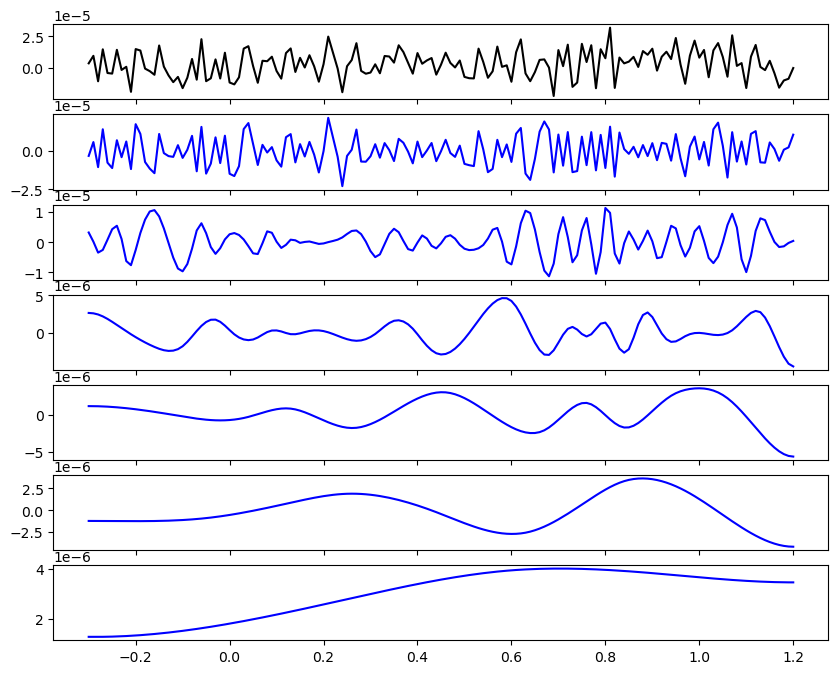

Loading Epochs for S027...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/2325919881.py:38: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S027_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/2325919881.py:49: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Data Loaded Successfully: 151 samples
Running Layer 1 Sift...
Running Layer 2 Sift...


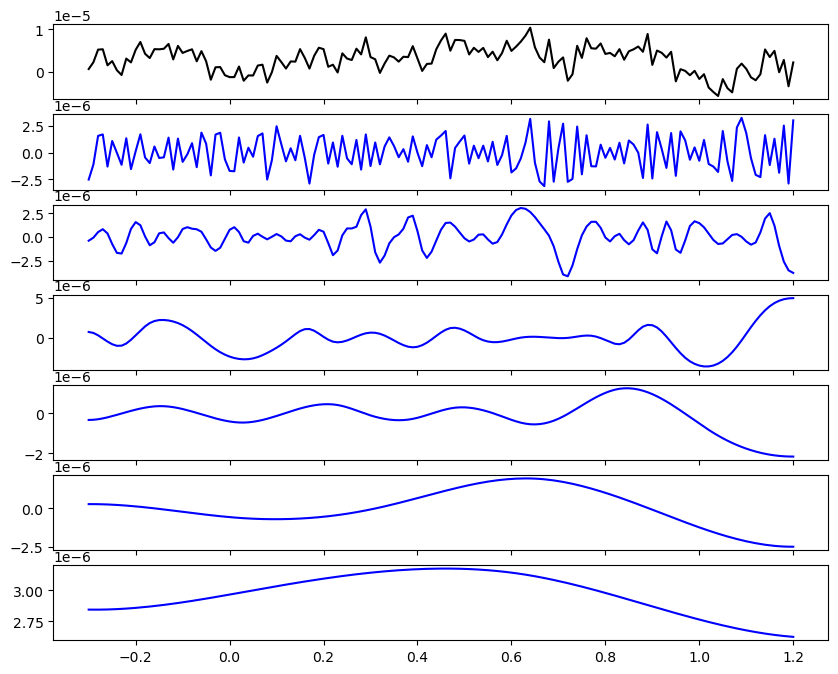

Loading Epochs for S023...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/2325919881.py:38: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S023_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/2325919881.py:49: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Data Loaded Successfully: 151 samples
Running Layer 1 Sift...
Running Layer 2 Sift...


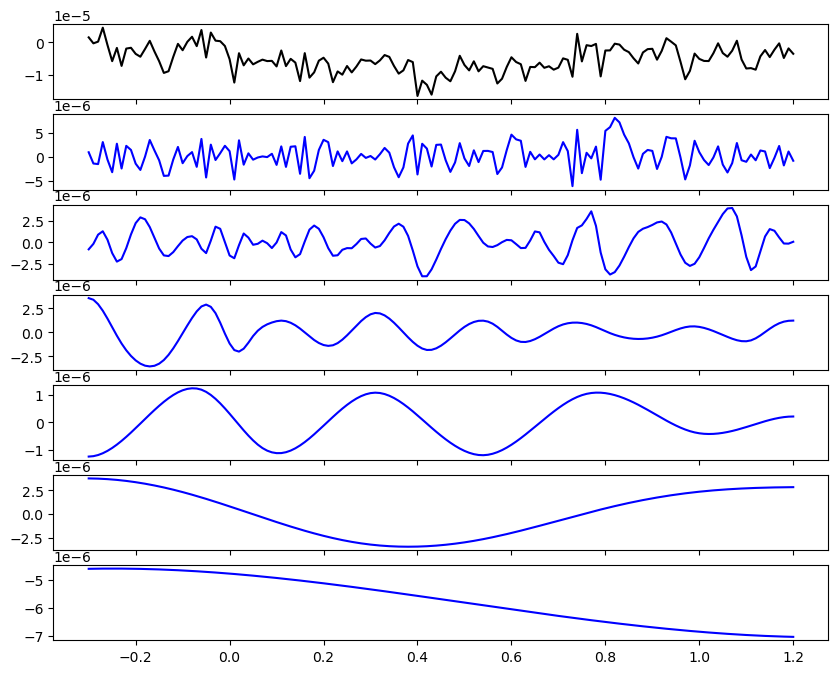

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import mne
from pathlib import Path
import emd
from scipy.signal import hilbert
import gc # Garbage Collector

# THIS WORKS!!!!
# ==========================================
# 1. CONFIGURATION
# ==========================================
DATA_ROOT = Path("/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results")
#EPOCH_DIR = DATA_ROOT / 'wOnset_epochs' 
#TARGET_SUBJECT = 'S011' 

for subject in ESL_SUBJECTS[0:3]:
    TARGET_SUBJECT = subject[4:8]
    # Selection parameters
    TRIAL_INDEX = 0      
    CHANNEL_NAME = 'FP1' # Change this to your actual channel name (e.g., 'Cz')
    TARGET_IMF_INDEX = 1 
    
    # ==========================================
    # 2. LOAD DATA (MNE Epochs)
    # ==========================================
    # Fixed filename to match your exact saved file from the warning
    file_name = f'{TARGET_SUBJECT}_ESLs_wOnset_epochs_allTapes_raw.fif'
    file_path = wOnset_DIR / file_name
    
    print(f"Loading Epochs for {TARGET_SUBJECT}...")
    
    # Initialize signal as None to prevent NameError later
    signal = None
    
    try:
        # Use verbose=False to quiet the naming convention warning
        epochs = mne.read_epochs(file_path, preload=True, verbose=False)
        
        # 1. Pick Channel (Check if channel exists first)
        if CHANNEL_NAME not in epochs.ch_names:
            print(f"Warning: {CHANNEL_NAME} not found. Using first available channel: {epochs.ch_names[0]}")
            CHANNEL_NAME = epochs.ch_names[0]
        
        epochs.pick_channels([CHANNEL_NAME])
        
        # 2. Extract Data 
        # MNE shape: (trials, channels, times)
        data = epochs.get_data() 
        
        # Ensure it's a 1D array for EMD
        signal = data[TRIAL_INDEX, 0, :].flatten()
        
        times = epochs.times
        fs = epochs.info['sfreq']
        
        # Clean up epoch object to save RAM
        del epochs
        gc.collect()
    
        print(f"Data Loaded Successfully: {len(signal)} samples")
    
    except Exception as e:
        print(f"FATAL ERROR during loading: {e}")
        # Stop execution if data didn't load
        raise 
    
    # ==========================================
    # 3. PROCESSING (Only runs if signal exists)
    # ==========================================
    
    if signal is not None:
        # --- A. Layer 1 Decomposition ---
        # Mirror Padding to prevent edge effects
        pad_width = len(signal)
        padded_signal = np.pad(signal, pad_width, mode='reflect')
    
        print("Running Layer 1 Sift...")
        # Using sift (standard) or ensemble_sift (CEEMDAN-like)
        # nprocesses helps speed but can crash some kernels; set to 1 if it crashes
        imfs_layer1_padded = emd.sift.sift(padded_signal, max_imfs=5)
    
        # Un-pad
        imfs_layer1 = imfs_layer1_padded[pad_width : pad_width + len(signal), :]
        n_imfs1 = imfs_layer1.shape[1]
    
        # --- B. Layer 2 Decomposition ---
        target_imf_padded = imfs_layer1_padded[:, TARGET_IMF_INDEX]
    
        # Analytic signal for envelope
        analytic = hilbert(target_imf_padded)
        envelope_padded = np.abs(analytic)
    
        print("Running Layer 2 Sift...")
        imfs_layer2_padded = emd.sift.sift(envelope_padded, max_imfs=4)
    
        # Un-pad
        envelope_real = envelope_padded[pad_width : pad_width + len(signal)]
        imfs_layer2 = imfs_layer2_padded[pad_width : pad_width + len(signal), :]
        n_imfs2 = imfs_layer2.shape[1]
    
        # ==========================================
        # 4. PLOTTING
        # ==========================================
        # (Plotting code remains the same as previous)
        fig1, axes1 = plt.subplots(n_imfs1 + 1, 1, figsize=(10, 8), sharex=True)
        axes1[0].plot(times, signal, 'k')
        for i in range(n_imfs1):
            axes1[i+1].plot(times, imfs_layer1[:, i], 'b')
        plt.savefig(wOnset_DIR / Path('ESLs_%s_%s_layer1-IMFs_wOnset.png' %(TARGET_SUBJECT, CHANNEL_NAME)))
        plt.show()
    
    else:
        print("Processing skipped because signal was not defined.")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import mne
import emd
from pathlib import Path
from scipy.signal import hilbert
import gc

# ==========================================
# 1. CONFIGURATION
# ==========================================
DATA_ROOT = Path("/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results")
# Using the directory where your epochs are saved
EPOCH_DIR = DATA_ROOT / 'wOnset_epochs' 
TARGET_SUBJECT = 'S011'
CHANNEL_NAME = 'FP1' 
TRIAL_INDEX = 0          

# --- SELECT CARRIER TO ANALYZE ---
# 0 = IMF 1 (Theta/Acoustic), 1 = IMF 2 (Delta/Word), 2 = IMF 3 (Phrasal)
TARGET_IMF_L1 = 1        

# Heatmap Settings
NBINS = 60
LIMIT_CARRIER = 12       
LIMIT_AM = 6             

# ==========================================
# 2. LOAD DATA
# ==========================================
file_name = f'{TARGET_SUBJECT}_ESLs_wOnset_epochs_allTapes_raw.fif'
file_path = EPOCH_DIR / file_name # Use your actual path variable here

try:
    epochs = mne.read_epochs(file_path, preload=True, verbose=False)
    epochs.pick_channels([CHANNEL_NAME])
    signal = epochs.get_data()[TRIAL_INDEX, 0, :].flatten()
    fs = epochs.info['sfreq']
    times = epochs.times
    del epochs
    gc.collect()
except Exception as e:
    print(f"Error: {e}")
    raise

# ==========================================
# 3. HHSA PROCESSING (Two-Layer EMD)
# ==========================================
pad_width = len(signal)
padded_signal = np.pad(signal, pad_width, mode='reflect')

# Layer 1: Carrier
imfs_l1_padded = emd.sift.sift(padded_signal, max_imfs=5)
imfs_l1 = imfs_l1_padded[pad_width : pad_width + len(signal), :]

# Layer 2: Modulation (Decomposing the Envelope of selected IMF)
target_imf_padded = imfs_l1_padded[:, TARGET_IMF_L1]
envelope_padded = np.abs(hilbert(target_imf_padded))
imfs_l2_padded = emd.sift.sift(envelope_padded, max_imfs=4)

imfs_l2 = imfs_l2_padded[pad_width : pad_width + len(signal), :]
envelope_real = envelope_padded[pad_width : pad_width + len(signal)]

# ==========================================
# 4. SPECTRAL HEATMAP CALCULATION
# ==========================================
def get_inst_info(sig, sr):
    analytic = hilbert(sig)
    phase = np.unwrap(np.angle(analytic))
    freq = np.append(np.diff(phase) / (2.0 * np.pi) * sr, 0)
    return freq

freq_carrier = get_inst_info(imfs_l1[:, TARGET_IMF_L1], fs)
all_points = []

for j in range(imfs_l2.shape[1]):
    freq_am = get_inst_info(imfs_l2[:, j], fs)
    power_am = imfs_l2[:, j]**2
    mask = (freq_carrier > 0) & (freq_carrier < LIMIT_CARRIER) & \
           (freq_am > 0) & (freq_am < LIMIT_AM)
    if np.any(mask):
        all_points.append(np.vstack((freq_carrier[mask], freq_am[mask], power_am[mask])).T)

holo_data = np.vstack(all_points)

# ==========================================
# 5. PLOTTING
# ==========================================
# Robust plotting helper to avoid math domain errors
def safe_plot(data, sr, title):
    plt.figure(figsize=(10, 6))
    emd.plotting.plot_imfs(data + 1e-12, sample_rate=sr, sharey=False)
    plt.suptitle(title, fontsize=14)
    plt.subplots_adjust(top=0.9)
    plt.show()

# Figure 1: Layer 1
safe_plot(np.hstack((signal[:, np.newaxis], imfs_l1)), fs, 
          f"{TARGET_SUBJECT}: Layer 1 Carrier IMFs")

# Figure 2: Layer 2
safe_plot(np.hstack((envelope_real[:, np.newaxis], imfs_l2)), fs, 
          f"{TARGET_SUBJECT}: Layer 2 AM IMFs (of Carrier IMF {TARGET_IMF_L1+1})")

# Figure 3: Heatmap
H, x_e, y_e = np.histogram2d(holo_data[:, 0], holo_data[:, 1], bins=NBINS, 
                             weights=holo_data[:, 2], range=[[0, LIMIT_CARRIER], [0, LIMIT_AM]])
plt.figure(figsize=(7, 5))
plt.imshow(H.T, origin='lower', cmap='jet', aspect='auto', interpolation='gaussian',
           extent=[0, LIMIT_CARRIER, 0, LIMIT_AM])
plt.title(f'HHSA Heatmap: {TARGET_SUBJECT} (Carrier IMF {TARGET_IMF_L1+1})')
plt.xlabel('Carrier Freq (Hz)')
plt.ylabel('AM Freq (Hz)')
plt.colorbar(label='Power')
plt.show()

In [ ]:
"""
import numpy as np
import matplotlib.pyplot as plt
import eelbrain
from pathlib import Path
import emd
from scipy.signal import hilbert
"""
# Version 1 of IMFs in each layers (=second EMD)

# ==========================================
# 1. CONFIGURATION
# ==========================================
DATA_ROOT = Path("/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results")
TRF_DIR = DATA_ROOT / 'TRFs_ESLs'
TARGET_MODEL = 'Fzero+envelope'
TARGET_SUBJECT = 'S010'  # <--- Change this to look at different subjects

# Which Layer 1 IMF do you want to decompose further?
# 0 = First IMF (Fastest/Highest Freq), 1 = Second IMF, etc.
TARGET_IMF_INDEX = 1 

# ==========================================
# 2. LOAD DATA (Robust Loading)
# ==========================================
file_path = TRF_DIR / TARGET_SUBJECT / f'{TARGET_SUBJECT} {TARGET_MODEL}.pickle'
print(f"Loading {TARGET_SUBJECT}...")

try:
    trf_obj = eelbrain.load.unpickle(file_path)
    
    # Handle h vs h_scaled
    if hasattr(trf_obj, 'h_scaled'):
        data_ndvar = trf_obj.h_scaled
    else:
        data_ndvar = trf_obj.h
        
    # Handle Tuple
    if isinstance(data_ndvar, tuple):
        data_ndvar = data_ndvar[0]

    # Extract Predictor (Strategy: Index)
    # Assumes order is [F0, Envelope] -> Index 1 is Envelope
    # If your model is just 'envelope', it might be Index 0.
    try:
        # Try finding 'envelope' by name
        trf_final = data_ndvar['envelope']
        pred_name = "Envelope"
    except:
        # Fallback to Index 1
        dims = data_ndvar.dimnames
        non_time_dims = [d for d in dims if d != 'time' and d != 'sensor']
        if len(non_time_dims) > 0:
            trf_final = data_ndvar.sub(**{non_time_dims[0]: 1})
            pred_name = "Predictor (Index 1)"
        else:
            trf_final = data_ndvar
            pred_name = "Predictor"

    # Average Sensors
    if 'sensor' in trf_final.dimnames:
        trf_final = trf_final.mean('sensor')
        
    signal = trf_final.x
    times = trf_final.time.times
    fs = 1.0 / trf_final.time.tstep

    if signal.ndim > 1: signal = signal.flatten()
    print(f"Data Loaded: {len(signal)} samples")

except Exception as e:
    print(f"Error loading: {e}")
    exit()

# ==========================================
# 3. PROCESSING (With Mirror Padding)
# ==========================================

# --- A. Layer 1 Decomposition ---
pad_width = len(signal)
padded_signal = np.pad(signal, pad_width, mode='reflect')

# Run EMD (Sift)
imfs_layer1_padded = emd.sift.sift(padded_signal, max_imfs=5)

# Un-pad Layer 1
# Note: emd output is (Samples, IMFs)
imfs_layer1 = imfs_layer1_padded[pad_width : pad_width + len(signal), :]
n_imfs1 = imfs_layer1.shape[1]

# --- B. Layer 2 Decomposition (Target IMF) ---
# Extract the target IMF (e.g., IMF 0)
target_imf_padded = imfs_layer1_padded[:, TARGET_IMF_INDEX]

# Get Envelope (using Hilbert)
analytic = hilbert(target_imf_padded)
envelope_padded = np.abs(analytic)

# Run EMD on Envelope
imfs_layer2_padded = emd.sift.sift(envelope_padded, max_imfs=4)

# Un-pad Layer 2
envelope_real = envelope_padded[pad_width : pad_width + len(signal)]
imfs_layer2 = imfs_layer2_padded[pad_width : pad_width + len(signal), :]
n_imfs2 = imfs_layer2.shape[1]

# ==========================================
# 4. PLOTTING
# ==========================================

# --- FIGURE 1: LAYER 1 (Carrier) ---
fig1, axes1 = plt.subplots(n_imfs1 + 1, 1, figsize=(10, 8), sharex=True)
fig1.suptitle(f"Layer 1: Carrier Decomposition ({TARGET_SUBJECT})", fontsize=14)

# Plot Original Signal
axes1[0].plot(times, signal, 'k', label='Original TRF')
axes1[0].set_title(f"Original Signal: {pred_name}")
axes1[0].legend(loc='upper right')

# Plot IMFs
for i in range(n_imfs1):
    ax = axes1[i + 1]
    ax.plot(times, imfs_layer1[:, i], 'b')
    ax.set_ylabel(f"IMF {i+1}")
    ax.grid(True, alpha=0.3)

axes1[-1].set_xlabel("Time (s)")
plt.tight_layout()
#plt.savefig(TRF_DIR / 'ESLs_S010_layer1-IMFs_HHSA_TRF.png')
plt.show()


# --- FIGURE 2: LAYER 2 (Amplitude Modulation) ---
fig2, axes2 = plt.subplots(n_imfs2 + 1, 1, figsize=(10, 8), sharex=True)
fig2.suptitle(f"Layer 2: AM Decomposition of Carrier IMF {TARGET_IMF_INDEX+1}", fontsize=14)

# Plot Envelope
axes2[0].plot(times, envelope_real, 'r', label=f'Envelope of IMF {TARGET_IMF_INDEX+1}')
axes2[0].set_title("Amplitude Envelope (Input to Layer 2)")
axes2[0].legend(loc='upper right')

# Plot AM IMFs
for i in range(n_imfs2):
    ax = axes2[i + 1]
    ax.plot(times, imfs_layer2[:, i], 'g')
    ax.set_ylabel(f"AM IMF {i+1}")
    ax.grid(True, alpha=0.3)

axes2[-1].set_xlabel("Time (s)")
plt.tight_layout()
plt.savefig(TRF_DIR / 'ESLs_S010_layer2-IMF2_HHSA_TRF.png')
plt.show()